In [14]:
import importlib, helper_tools, Data

importlib.reload(helper_tools)
print("has spectral_d_dz?", hasattr(helper_tools, "spectral_d_dz"))  # should be True

importlib.reload(Data)   # now succeeds

has spectral_d_dz? True


<module 'Data' from 'c:\\Users\\Raeed\\Desktop\\PhD\\HR realization\\Data.py'>

In [113]:

import importlib, helper_tools, Data
importlib.reload(helper_tools)
importlib.reload(Data)

# import the classes (class names, not modules)
from Box import Box
from Cosmology import Cosmology
from Data import Data
import helper_tools, pspectra  # if needed elsewhere
from helper_tools import make_triangular_rays_mask

box = Box(128, 1000)
cosmo = Cosmology(1, 67.4, 0.8, 0.315, 0.674, 0.965, 1.0)
data = Data(box, cosmo)
data.generate_mock_fields()


C:\Users\Raeed\AppData\Local\Temp\ipykernel_25224\1590660054.py:75: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1].loglog(k[mask], (k[mask]**2)*P_meas[mask], label="Measured $P(k)$", lw=2)


Median P_meas / P_theory = 0.9999875980166056


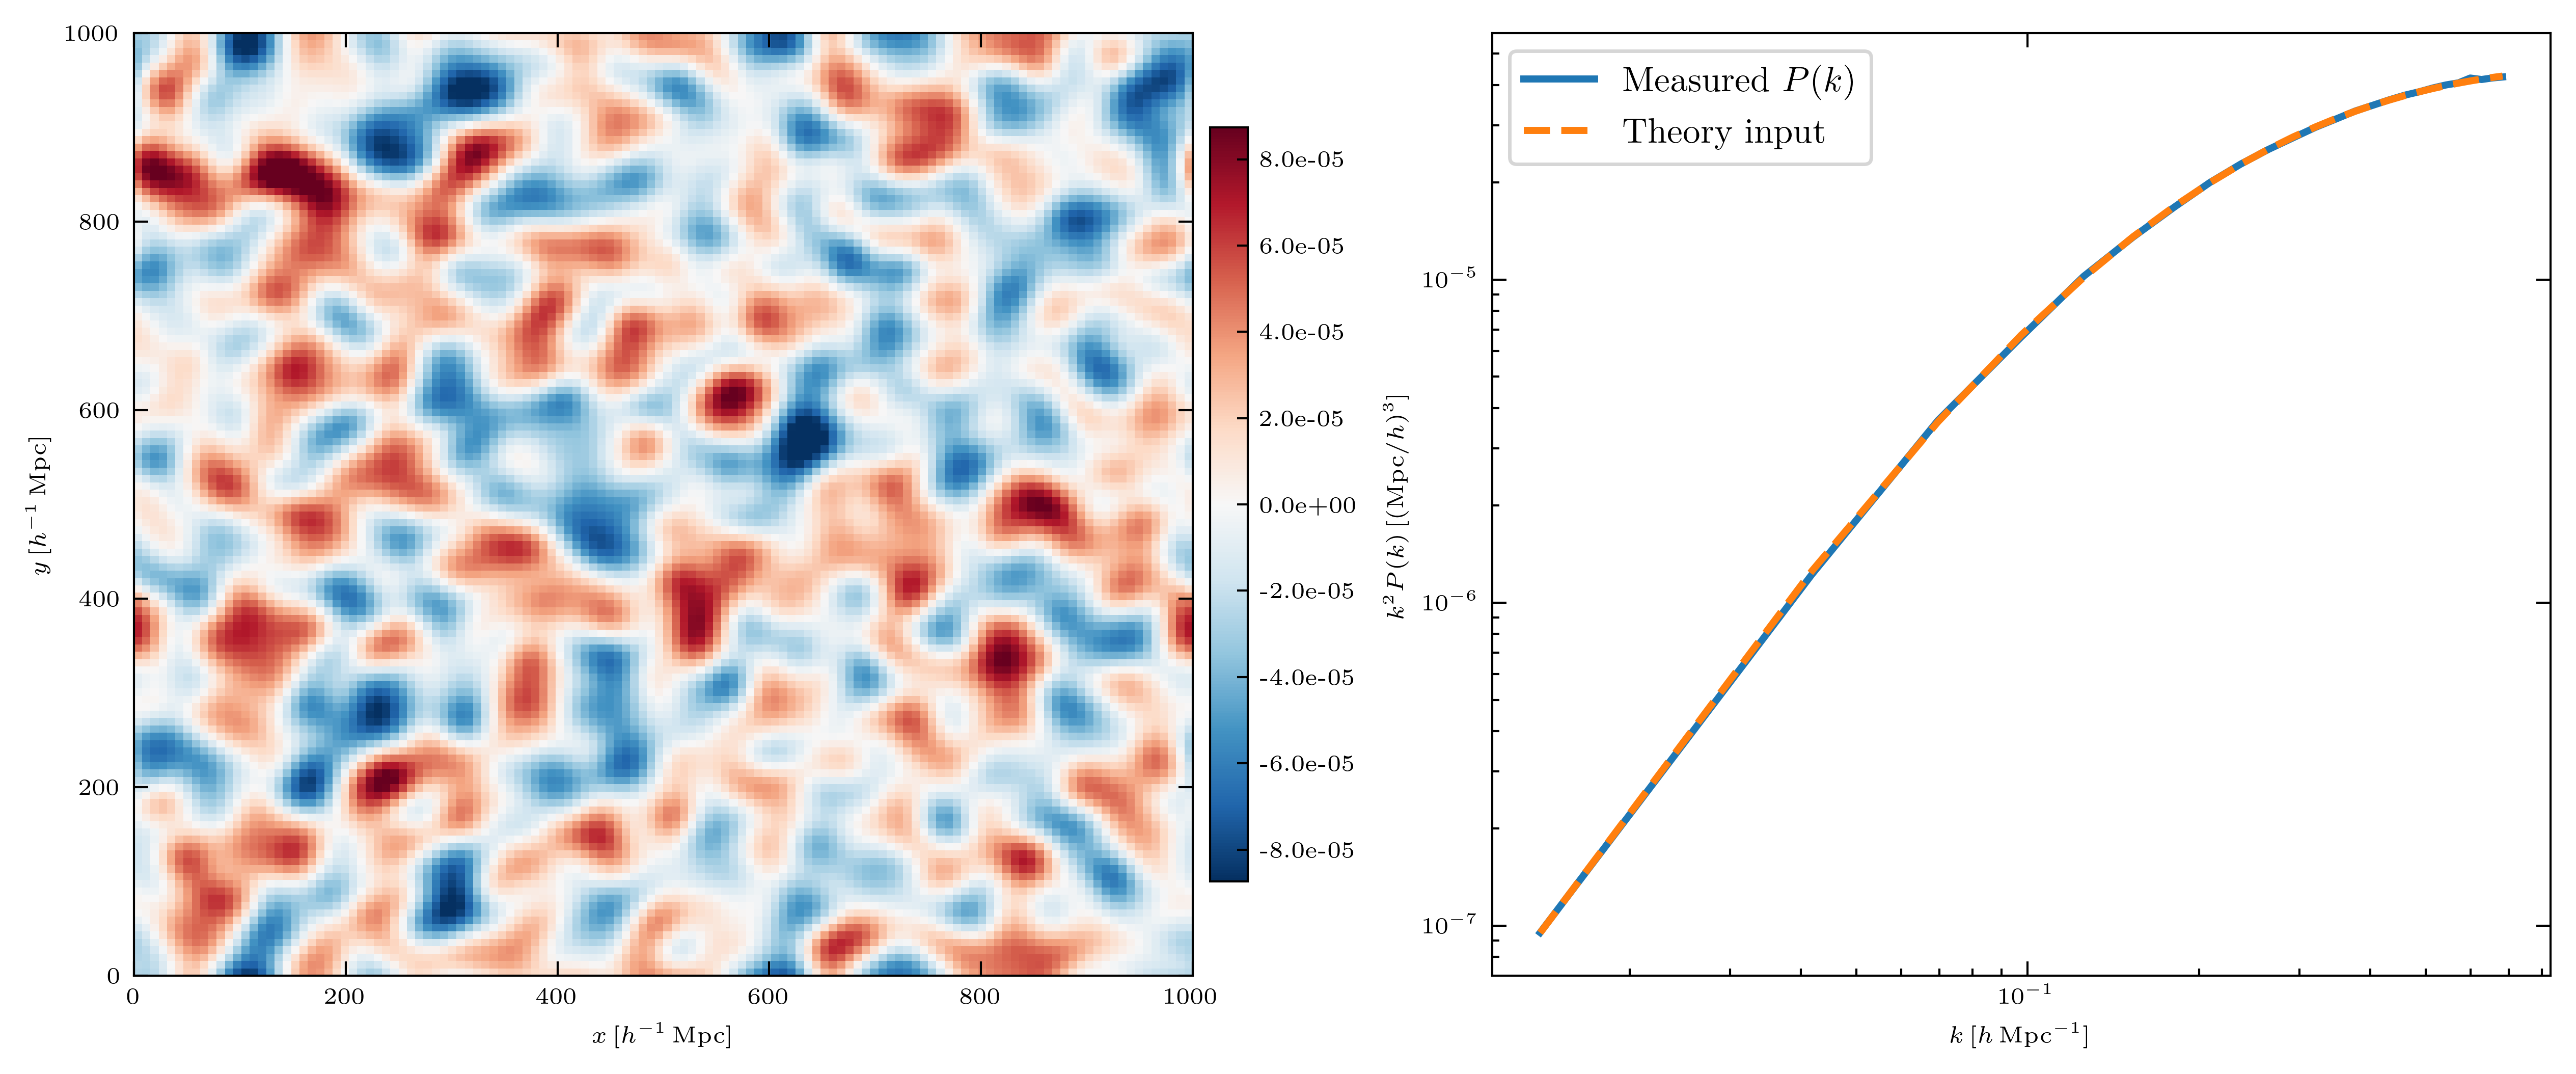

In [114]:
# === Smooth slice + Power spectrum (side by side) ===
import importlib, helper_tools
importlib.reload(helper_tools)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from helper_tools import gaussian_smooth_fft, shell_power_rfft
from pspectra import Pk_phys_nowiggle


# --- grab field & sanity ---
assert getattr(data, "delta_r", None) is not None, "data.delta_r is None. Run data.generate_mock_fields() first."
delta = data.delta_r
n, L = data.box.n, data.box.L

# --- smoothing ---
R_smooth = 20.0  # Mpc/h (tune this)
delta_sm = gaussian_smooth_fft(delta, data.box, R_smooth)

# --- slice for image ---
iz = n // 2
sl_smooth = delta_sm[:, :, iz]
vmax = np.percentile(np.abs(sl_smooth), 99.5)
vmin = -vmax
extent = [0, L, 0, L]  # x,y in Mpc/h

# --- 1D shell-averaged P(k) from the raw field (not the smoothed one) ---
NBINS = 25
k, P_meas, _ = shell_power_rfft(delta, L, NBINS)

# --- theory P(k) using data.cosmology if available, else sensible defaults ---
cosmo = getattr(data, "cosmology", None)
params = dict(
    Om=getattr(cosmo, "Om", 0.315),
    h=getattr(cosmo, "h", 0.674),
    ns=getattr(cosmo, "ns", 0.965),
    A=getattr(cosmo, "A", 1.0),
)
P_th = Pk_phys_nowiggle(k, **params)

# --- plot side by side ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",                # Computer Modern by default
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})

# Preamble: load AMS packages (as a single string)
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"
fig, axes = plt.subplots(1, 2, figsize=(10, 4.1), dpi=500, constrained_layout=True)

# (left) smoothed slice
im = axes[0].imshow(sl_smooth.T, origin="lower", extent=extent, vmin=vmin, vmax=vmax, cmap="RdBu_r")
# colorbar: push it to the right & style fonts
cbar = fig.colorbar(
    im, ax=axes[0],
    shrink=0.8,          # keep your height
    fraction=0.05,       # bar thickness (relative to ax width)
    pad=-0.01,            # gap between image and colorbar (positive moves it right)
    format="%.1e"
)
cbar.ax.tick_params(labelsize=6.5, width=0.6, length=3, direction="in")
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.6)

plt.axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)
axes[0].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)
# (right) measured vs theory power spectrum
mask = k > 0  # drop DC
axes[1].loglog(k[mask], (k[mask]**2)*P_meas[mask], label="Measured $P(k)$", lw=2)
axes[1].loglog(k[mask], (k[mask]**2)*P_th[mask],   label="Theory input", lw=2, ls="--")
axes[1].legend()
plt.axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1].set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$", fontsize=6.5)
axes[1].set_ylabel(r"$k^2P(k)\,[(\mathrm{Mpc}/h)^3]$", fontsize=6.5)
# Tick formatting
def bold_formatter(x, pos):
    return r'${:.3f}$'.format(x)
def bold_formatter_int(x, pos):
    return r'${:.0f}$'.format(x)
for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='both', which='both', direction='in', labelsize=6.5)
    ax.tick_params(axis='both', which='major', length=4, width=0.6)
    ax.tick_params(axis='both', which='minor', length=2, width=0.6)
    ax.tick_params(top=True, bottom=True, left=True, right=True)
    if i == 0:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
    ax.set_aspect("auto")

plt.savefig('mock_overdensity_and_p_spectra', dpi=500)
# quick amplitude check
scale = np.nanmedian(P_meas[mask] / P_th[mask])
print("Median P_meas / P_theory =", scale)


C:\Users\Raeed\AppData\Local\Temp\ipykernel_25224\2138633363.py:77: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1].loglog(k[mask], (k[mask]**2) * Pphi_meas[mask], label=r"Measured $P_{\phi}(k)$", lw=2)


Median P_phi_meas / P_phi_theory = 1.0093103841606514


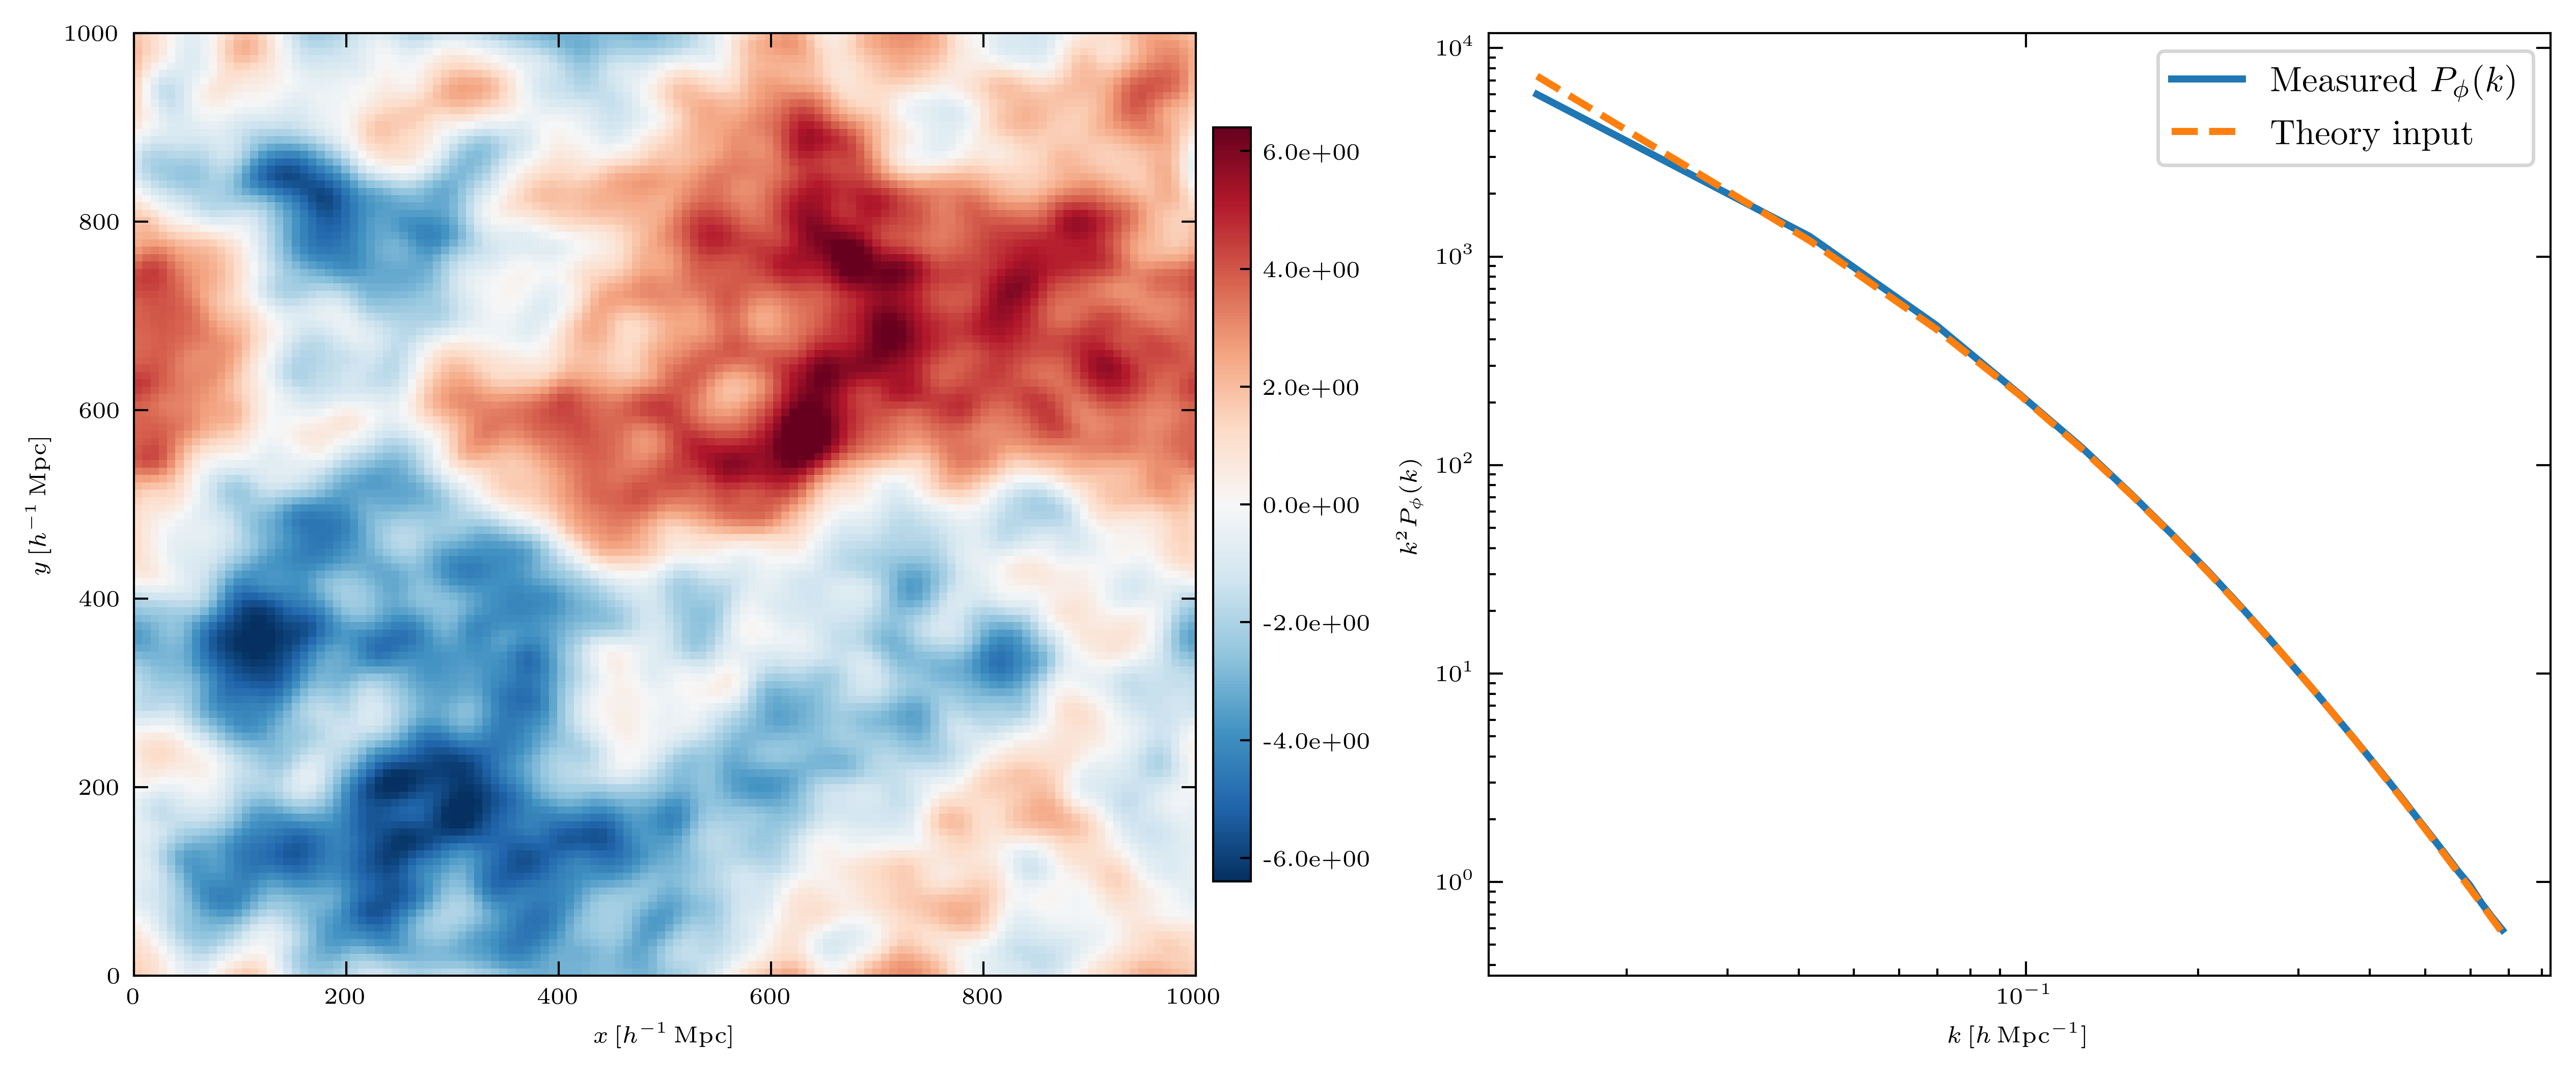

In [17]:
# === Smooth slice + Phi power spectrum (side by side) ===
import importlib, helper_tools
importlib.reload(helper_tools)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from helper_tools import gaussian_smooth_fft, shell_power_rfft
from pspectra import Pk_phys_nowiggle

# --- grab field & sanity ---
assert getattr(data, "phi", None) is not None, "data.phi is None. Run data.generate_mock_fields() first."
phi = data.phi
n, L = data.box.n, data.box.L

# --- smoothing ---
R_smooth = 10.0  # Mpc/h (tune this)
phi_sm = gaussian_smooth_fft(phi, data.box, R_smooth)

# --- slice for image ---
iz = n // 2
sl_smooth = phi_sm[:, :, iz]
vmax = np.percentile(np.abs(sl_smooth), 99.5)
vmin = -vmax
extent = [0, L, 0, L]  # x,y in Mpc/h

# --- 1D shell-averaged P_phi(k) from the raw field (not the smoothed one) ---
NBINS = 25
k, Pphi_meas, _ = shell_power_rfft(phi, L, NBINS)

# --- theory P_phi(k) via P_delta(k): P_phi = (a H f)^2 P_delta / k^4 ---
cosmo = getattr(data, "cosmology", None)
params = dict(
    Om=getattr(cosmo, "Om", 0.315),
    h=getattr(cosmo, "h", 0.674),
    ns=getattr(cosmo, "ns", 0.965),
    A=getattr(cosmo, "A", 1.0),
)
Pdelta_th = Pk_phys_nowiggle(k, **params)
a, H, f = getattr(cosmo, "a", 1.0), getattr(cosmo, "H", 100.0), getattr(cosmo, "f", 0.8)
k4 = np.maximum(k**4, np.finfo(float).tiny)  # avoid divide-by-zero at k=0
Pphi_th = (a * H * f)**2 * Pdelta_th / k4

# --- plot side by side (same style as your delta cell) ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",                # Computer Modern by default
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

fig, axes = plt.subplots(1, 2, figsize=(10, 4.1), dpi=500, constrained_layout=True)

# (left) smoothed slice of phi
im = axes[0].imshow(sl_smooth.T, origin="lower", extent=extent, vmin=vmin, vmax=vmax, cmap="RdBu_r")
# colorbar: keep your spacing/format choices
cbar = fig.colorbar(
    im, ax=axes[0],
    shrink=0.8,
    fraction=0.05,
    pad=-0.01,
    format="%.1e",
)
cbar.ax.tick_params(labelsize=6.5, width=0.6, length=3, direction="in")
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.6)

plt.axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)
axes[0].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)

# (right) measured vs theory power spectrum for phi
mask = k > 0  # drop DC
axes[1].loglog(k[mask], (k[mask]**2) * Pphi_meas[mask], label=r"Measured $P_{\phi}(k)$", lw=2)
axes[1].loglog(k[mask], (k[mask]**2) * Pphi_th[mask],   label=r"Theory input", lw=2, ls="--")
axes[1].legend()
plt.axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1].set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$", fontsize=6.5)
axes[1].set_ylabel(r"$k^2 P_{\phi}(k)$", fontsize=6.5)

# Tick formatting (keep your scheme)
def bold_formatter(x, pos):
    return r'${:.3f}$'.format(x)
def bold_formatter_int(x, pos):
    return r'${:.0f}$'.format(x)

for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='both', which='both', direction='in', labelsize=6.5)
    ax.tick_params(axis='both', which='major', length=4, width=0.6)
    ax.tick_params(axis='both', which='minor', length=2, width=0.6)
    ax.tick_params(top=True, bottom=True, left=True, right=True)
    if i == 0:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
    ax.set_aspect("auto")

plt.savefig('mock_phi_and_p_spectra', dpi=500)

# quick amplitude check
scale_phi = np.nanmedian(Pphi_meas[mask] / Pphi_th[mask])
print("Median P_phi_meas / P_phi_theory =", scale_phi)


In [20]:
# === Smooth slice + Phi power spectrum (side by side) ===
import importlib, Observed_Data
importlib.reload(Observed_Data)

from Observed_Data import ObservedData

obs_data_r = ObservedData(box, cosmo, mask=None, b_bias=1.7, dataset="real")
obs_data_r.generate_mock_fields()
obs_data_r.generate_artificial_noise(1.0, 0.0)
obs_data_r.add_noise_and_mask()
obs_data_s = ObservedData(box, cosmo, mask=None, b_bias=1.7, dataset="pp")
obs_data_s.generate_mock_fields()
obs_data_s.generate_artificial_noise(1.0, 0.0)
obs_data_s.add_noise_and_mask()

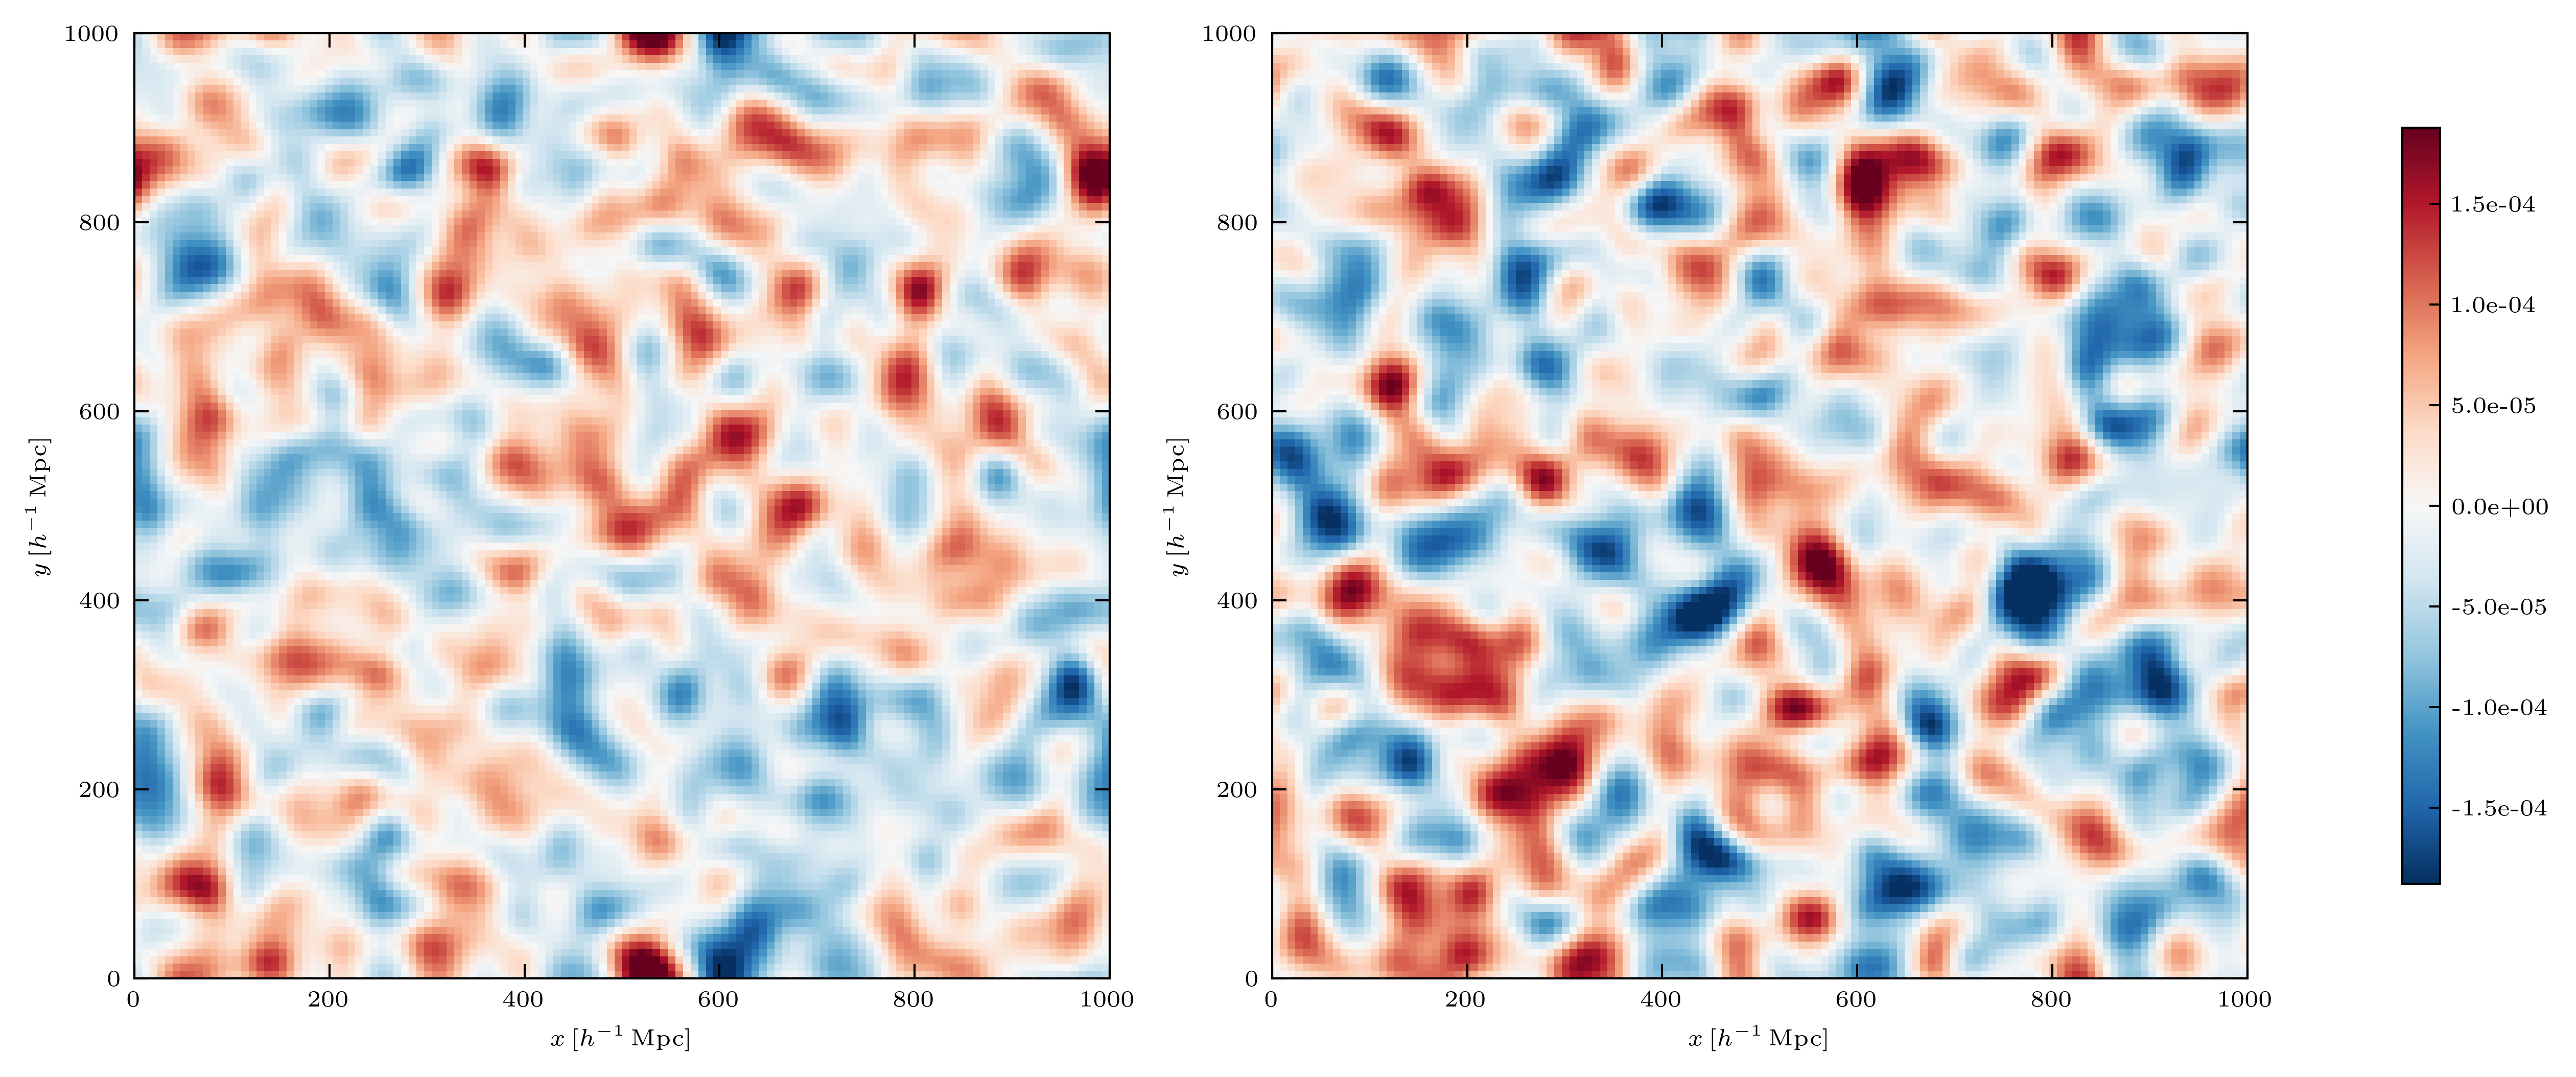

In [21]:
# === Smoothed observed maps (real vs PP), shared colorbar ===
import importlib, helper_tools
importlib.reload(helper_tools)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colors as mcolors
from helper_tools import gaussian_smooth_fft  # shell_power_rfft unused here

# --- grab fields & sanity ---
n, L = obs_data_r.box.n, obs_data_r.box.L
d_real = obs_data_r.d
d_rsd  = obs_data_s.d
assert d_real is not None and d_rsd is not None, "Call .make(...) on your ObservedData objects first."

# --- smoothing ---
R_smooth = 20.0  # Mpc/h
d_real = gaussian_smooth_fft(d_real, obs_data_r.box, R_smooth)
d_rsd  = gaussian_smooth_fft(d_rsd,  obs_data_s.box, R_smooth)

# --- central slice ---
iz = n // 2
sl_real = d_real[:, :, iz]
sl_rsd  = d_rsd[:, :, iz]

# shared symmetric color scale (robust)
vals = np.concatenate([sl_real.ravel(), sl_rsd.ravel()])
vmax = np.percentile(np.abs(vals), 99.5)
vmin = -vmax
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
extent = [0, L, 0, L]  # x,y in Mpc/h

# --- LaTeX plotting style ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

fig, axes = plt.subplots(1, 2, figsize=(10, 4.1), dpi=500, constrained_layout=True)

# (left) real-space observed slice
im0 = axes[0].imshow(sl_real.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[0].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)
axes[0].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)

# (right) PP-RSD observed slice
im1 = axes[1].imshow(sl_rsd.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[1].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)
axes[1].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)

# --- one shared colorbar for both axes ---
cbar = fig.colorbar(
    im1, ax=axes.ravel().tolist(),
    shrink=0.8,
    fraction=0.05,
    pad=0.06,       # positive pad moves it away from the plots
    format="%.1e",  # avoids separate ×10^n offset text
)
cbar.ax.tick_params(labelsize=6.5, width=0.6, length=3, direction="in")
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.6)

# Tick formatting on both main axes
def bold_formatter_int(x, pos): return r'${:.0f}$'.format(x)
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', direction='in', labelsize=6.5)
    ax.tick_params(axis='both', which='major', length=4, width=0.6)
    ax.tick_params(axis='both', which='minor', length=2, width=0.6)
    ax.tick_params(top=True, bottom=True, left=True, right=True)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
    ax.set_aspect("auto")

plt.savefig('observed_Data.png', dpi=500, bbox_inches="tight")


In [33]:
# === Smoothed observed maps (real vs PP), shared colorbar ===
import importlib, helper_tools, Reconstructed_Field, Wiener_solver
importlib.reload(helper_tools)
importlib.reload(Reconstructed_Field)
importlib.reload(Wiener_solver)

from Wiener_solver import Operators, Wiener_solve_realspace_fft, Wiener_solve_realspace_stencils, pcg, make_precond_Sphi_spectral, make_precond_Sphi_stencil
import pickle, time


# ---- Prior from P_delta(k) at z=0 (no-wiggle model here) ----
Pdelta_callable = lambda K: Pk_phys_nowiggle(K, Om=cosmo.Om, h=cosmo.h, ns=cosmo.ns, A=cosmo.A)

ops_fft = Operators(box, cosmo, Pdelta_callable=Pdelta_callable, use_lattice_in_fft=False)
ops_sten = Operators(box, cosmo, Pdelta_callable=Pdelta_callable)

phi_wiener_fft, A_fft, rhs_fft = Wiener_solve_realspace_fft(ops_fft, obs_data_r)
phi_wiener_sten, A_sten, rhs_sten = Wiener_solve_realspace_stencils(ops_sten, obs_data_r)

#---- Quick consistency checks ----
# Forward residuals
res_fft = np.linalg.norm(A_fft(phi_wiener_fft) - rhs_fft) / (np.linalg.norm(rhs_fft)+1e-30)
res_sten = np.linalg.norm(A_sten(phi_wiener_sten) - rhs_sten) / (np.linalg.norm(rhs_sten)+1e-30)
print(f"Relative residuals: spectral={res_fft:.3e}, stencil={res_sten:.3e}")

# Compare the two Wiener means (they should be very close)
diff = phi_wiener_fft - phi_wiener_sten
print(f"||phi_fft - phi_stencil|| / ||phi_fft|| = {np.linalg.norm(diff)/(np.linalg.norm(phi_wiener_fft)+1e-30):.3e}")




c:\Users\Raeed\Desktop\PhD\HR realization\pspectra.py:10: RuntimeWarning: invalid value encountered in divide
  return np.where(k > 0, L0/denom, 1.0)


[PCG] it=  1  |r|/|b|=4.662e-01
[PCG] it= 10  |r|/|b|=1.941e-04
[PCG] converged in 17 iters, time 7.44s
[Spectral L] total solve time: 7.87s
[PCG] it=  1  |r|/|b|=4.390e-01
[PCG] it= 10  |r|/|b|=1.572e-04
[PCG] converged in 16 iters, time 6.85s
[Stencil L] total solve time: 7.28s
Relative residuals: spectral=4.365e-07, stencil=8.308e-07
||phi_fft - phi_stencil|| / ||phi_fft|| = 3.665e-02


MSE(δ_rec vs d/b): spectral=9.386e-09, stencil=9.386e-09


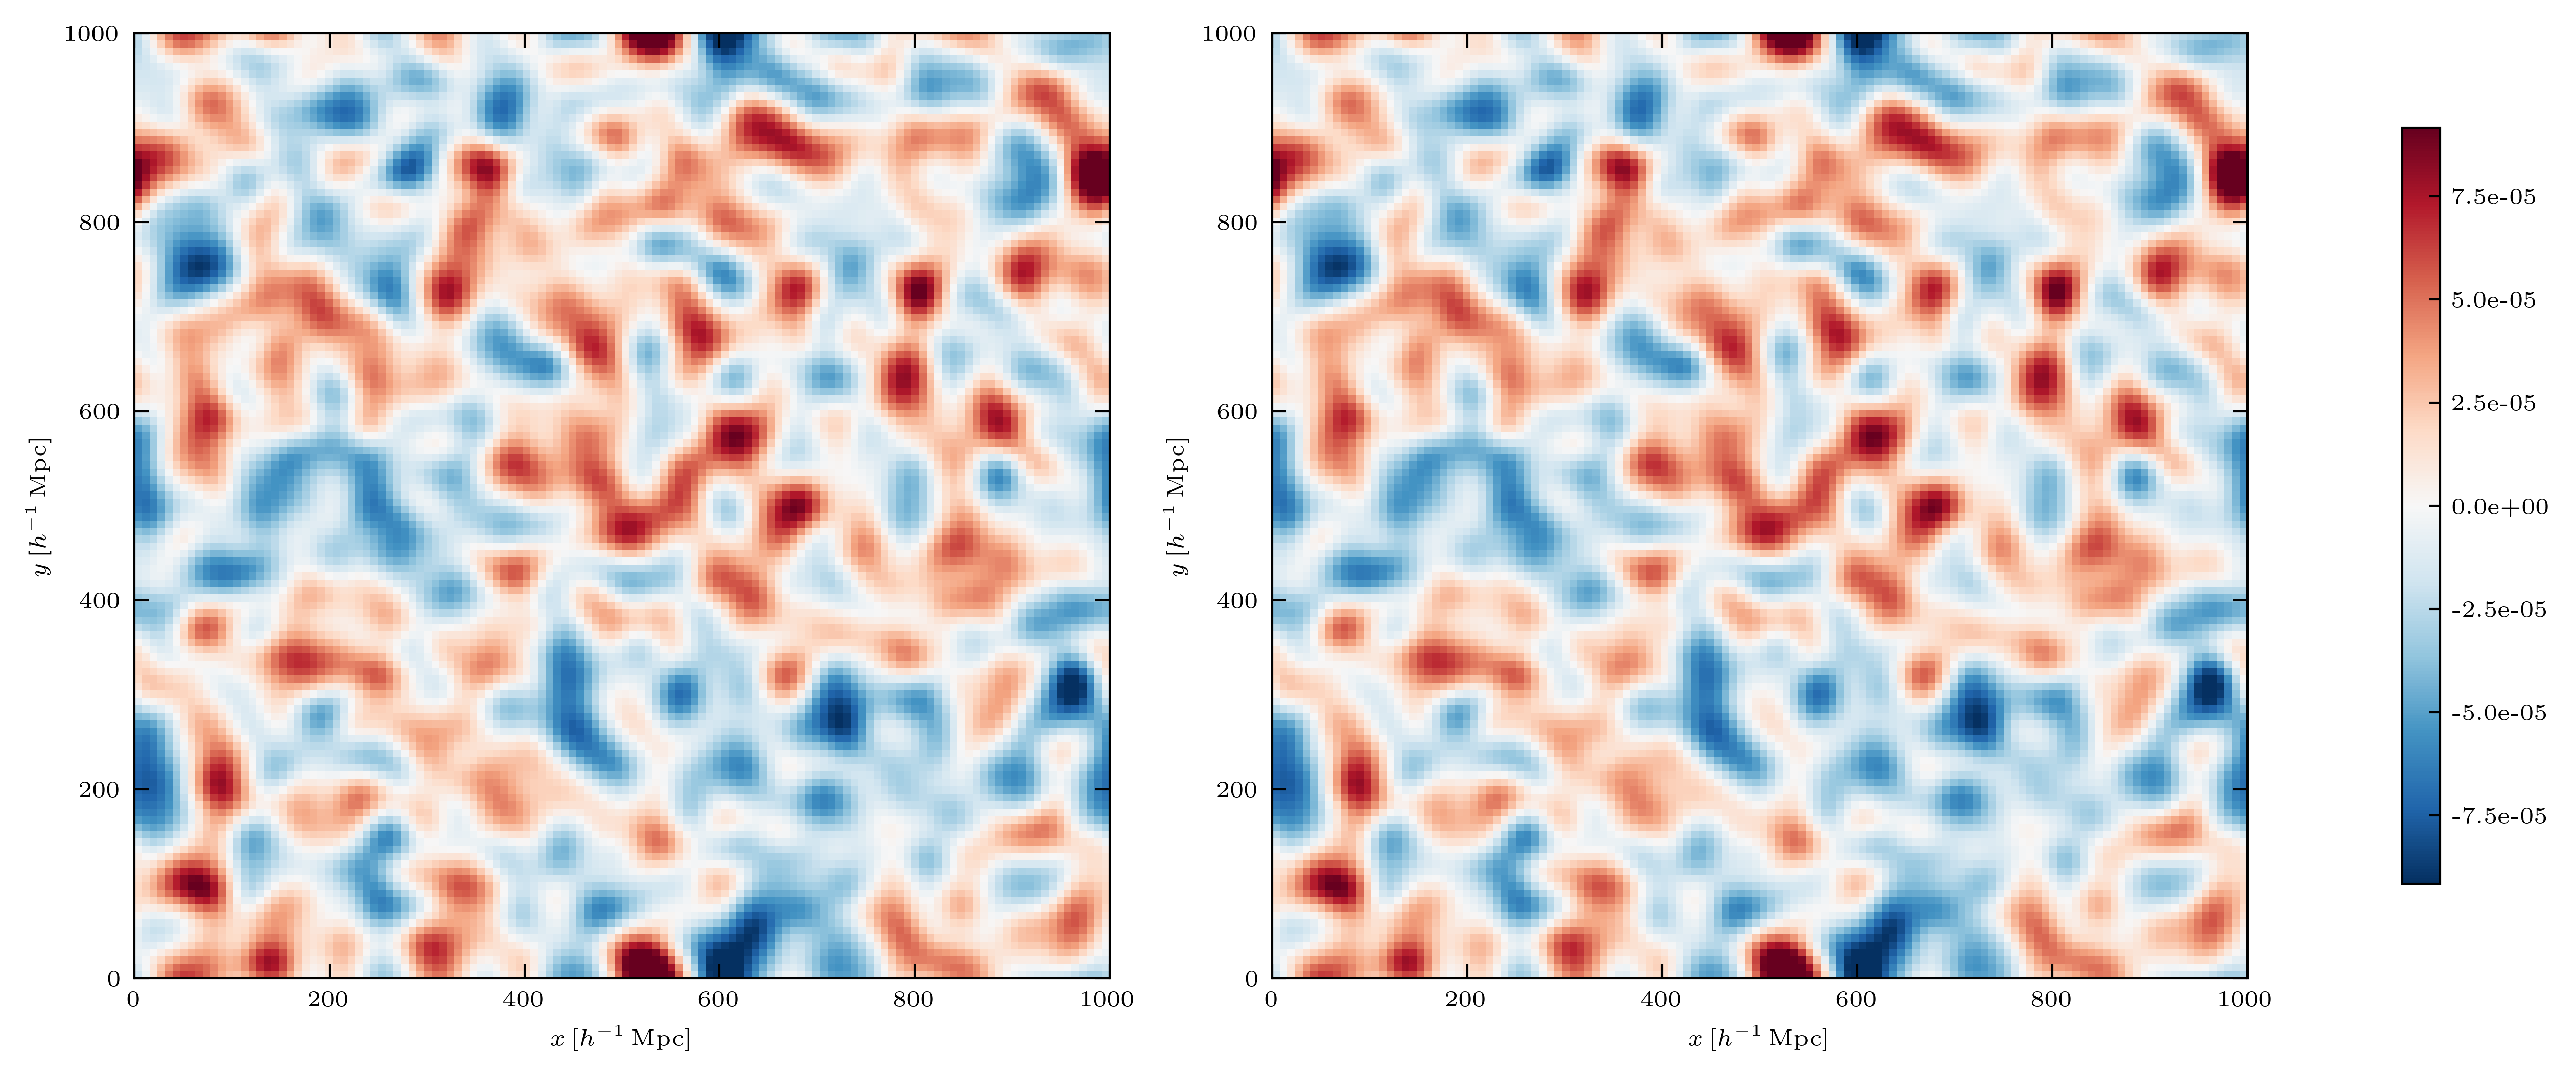

In [34]:
import Reconstructed_Field
importlib.reload(Reconstructed_Field)

from Reconstructed_Field import ReconstructedField

rec = ReconstructedField(box, cosmo, phi_wiener_sten, phi_wiener_fft)
b_bias = obs_data_r.b_bias
d = obs_data_r.d
delta_rec_fft  = rec.calc_delta_rec_from_phi_fft()
delta_rec_sten = rec.calc_delta_rec_from_phi_sten()
mse_fft  = np.mean((delta_rec_fft  - (d/b_bias))**2)
mse_sten = np.mean((delta_rec_sten - (d/b_bias))**2)

print(f"MSE(δ_rec vs d/b): spectral={mse_fft:.3e}, stencil={mse_sten:.3e}")

# === Smoothed observed maps (real vs PP), shared colorbar ===
import importlib, helper_tools
importlib.reload(helper_tools)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colors as mcolors
from helper_tools import gaussian_smooth_fft  # shell_power_rfft unused here

# --- grab fields & sanity ---
n, L = obs_data_r.box.n, obs_data_r.box.L

# --- smoothing ---
R_smooth = 20.0  # Mpc/h
fft = gaussian_smooth_fft(delta_rec_fft, obs_data_r.box, R_smooth)
sten  = gaussian_smooth_fft(delta_rec_sten,  obs_data_s.box, R_smooth)

# --- central slice ---
iz = n // 2
sl_fft = fft[:, :, iz]
sl_sten  = sten[:, :, iz]

# shared symmetric color scale (robust)
vals = np.concatenate([sl_fft.ravel(), sl_sten.ravel()])
vmax = np.percentile(np.abs(vals), 99.5)
vmin = -vmax
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
extent = [0, L, 0, L]  # x,y in Mpc/h

# --- LaTeX plotting style ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

fig, axes = plt.subplots(1, 2, figsize=(10, 4.1), dpi=500, constrained_layout=True)

# (left) real-space observed slice
im0 = axes[0].imshow(sl_fft.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[0].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)
axes[0].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)

# (right) PP-RSD observed slice
im1 = axes[1].imshow(sl_sten.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[1].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)
axes[1].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=6.5)

# --- one shared colorbar for both axes ---
cbar = fig.colorbar(
    im1, ax=axes.ravel().tolist(),
    shrink=0.8,
    fraction=0.05,
    pad=0.06,       # positive pad moves it away from the plots
    format="%.1e",  # avoids separate ×10^n offset text
)
cbar.ax.tick_params(labelsize=6.5, width=0.6, length=3, direction="in")
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.6)

# Tick formatting on both main axes
def bold_formatter_int(x, pos): return r'${:.0f}$'.format(x)
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', direction='in', labelsize=6.5)
    ax.tick_params(axis='both', which='major', length=4, width=0.6)
    ax.tick_params(axis='both', which='minor', length=2, width=0.6)
    ax.tick_params(top=True, bottom=True, left=True, right=True)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
    ax.set_aspect("auto")

plt.savefig('reconstructed_Data.png', dpi=500, bbox_inches="tight")


C:\Users\Raeed\AppData\Local\Temp\ipykernel_25224\2845436547.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


fft Median P_meas / P_theory = 1.0251761807436506
sten Median P_meas / P_theory = 0.7687199888622149


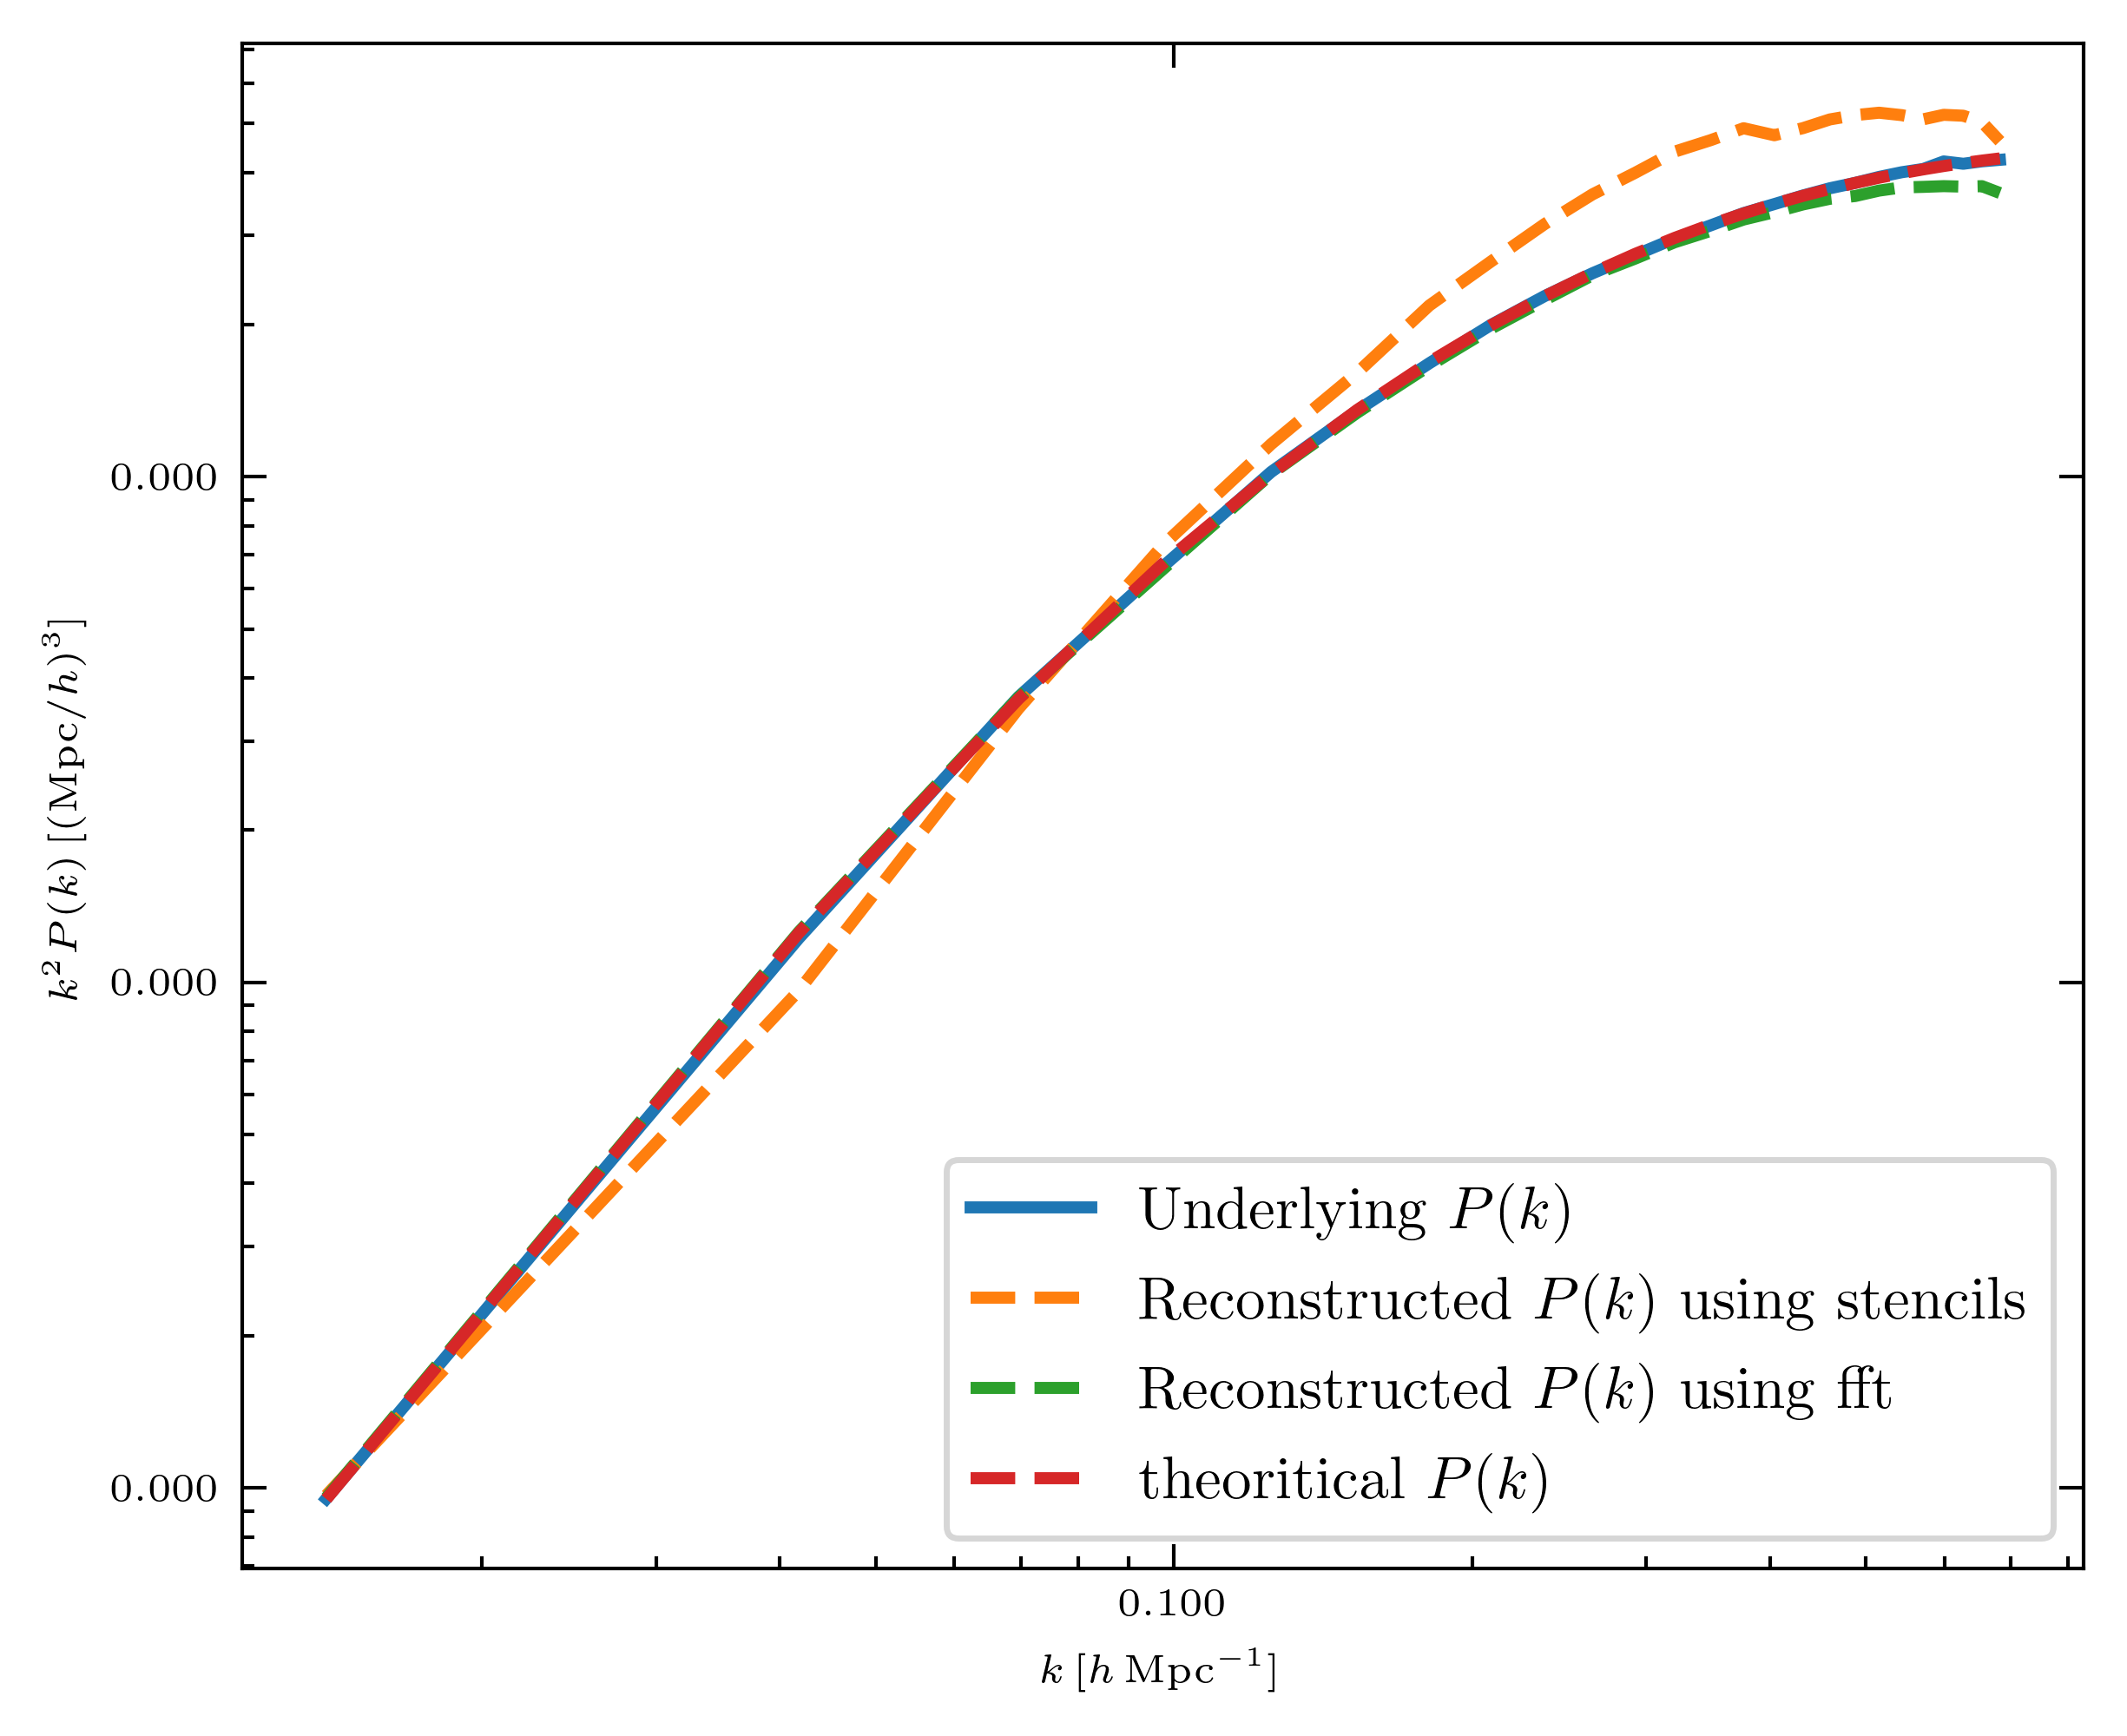

In [35]:
# === Smooth slice + Power spectrum (side by side) ===
import importlib, helper_tools
importlib.reload(helper_tools)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from helper_tools import gaussian_smooth_fft, shell_power_rfft, shell_power_rfft_stencil
from pspectra import Pk_phys_nowiggle


# --- 1D shell-averaged P(k) from the raw field (not the smoothed one) ---
NBINS = 25
k, P_meas, _ = shell_power_rfft(data.delta_r, L, NBINS)
k, P_meas_sten, _ = shell_power_rfft_stencil(delta_rec_sten, L, NBINS)
k, P_meas_fft, _ = shell_power_rfft(delta_rec_fft, L, NBINS)

# --- theory P(k) using data.cosmology if available, else sensible defaults ---
cosmo = getattr(data, "cosmology", None)
params = dict(
    Om=getattr(cosmo, "Om", 0.315),
    h=getattr(cosmo, "h", 0.674),
    ns=getattr(cosmo, "ns", 0.965),
    A=getattr(cosmo, "A", 1.0),
)
P_th = Pk_phys_nowiggle(k, **params)

# --- plot side by side ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",                # Computer Modern by default
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})

# Preamble: load AMS packages (as a single string)
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"
fig, axes = plt.subplots(figsize=(5, 4.1), dpi=500)


mask = k > 0  # drop DC
axes.loglog(k[mask], (k[mask]**2)*P_meas[mask], label="Underlying $P(k)$", lw=2)
axes.loglog(k[mask], (k[mask]**2)*P_meas_sten[mask], label="Reconstructed $P(k)$ using stencils", lw=2, ls="--")
axes.loglog(k[mask], (k[mask]**2)*P_meas_fft[mask], label="Reconstructed $P(k)$ using fft", lw=2, ls="--")
axes.loglog(k[mask], (k[mask]**2)*P_th[mask], label="theoritical $P(k)$", lw=2, ls="--")

axes.legend()
plt.axhline(0.0, lw=1, ls='--', alpha=0.7)
axes.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$", fontsize=6.5)
axes.set_ylabel(r"$k^2P(k)\,[(\mathrm{Mpc}/h)^3]$", fontsize=6.5)
# Tick formatting
def bold_formatter(x, pos):
    return r'${:.3f}$'.format(x)
def bold_formatter_int(x, pos):
    return r'${:.0f}$'.format(x)

axes.tick_params(axis='both', which='both', direction='in', labelsize=6.5)
axes.tick_params(axis='both', which='major', length=4, width=0.6)
axes.tick_params(axis='both', which='minor', length=2, width=0.6)
axes.tick_params(top=True, bottom=True, left=True, right=True)
axes.xaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter))
axes.yaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter))
for spine in axes.spines.values():
    spine.set_linewidth(0.6)
axes.set_aspect("auto")
plt.tight_layout()
plt.savefig('reconstructed_p_spectrum', dpi=500)
# quick amplitude check
scale_fft = np.nanmedian(P_meas[mask] / P_meas_fft[mask])
scale_sten = np.nanmedian(P_meas[mask] / P_meas_sten[mask])
print("fft Median P_meas / P_theory =", scale_fft)
print("sten Median P_meas / P_theory =", scale_sten)


In [154]:
import importlib, inspect, Data, Observed_Data

# Always reload base first, then subclass
importlib.reload(Data)
importlib.reload(Observed_Data)

# Re-create the object AFTER reloads
obs_data = Observed_Data.ObservedData(box, cosmo, mask=M, b_bias=1.7, dataset="real")

print("MRO:", [cls.__name__ for cls in obs_data.__class__.mro()])
print("Method resolution for sample_delta_from_Pk:")
meth = obs_data.sample_delta_from_Pk
print("  qualname:", getattr(meth, "__qualname__", str(meth)))
print("  module  :", getattr(meth, "__module__", str(meth)))
try:
    src = inspect.getsource(meth)
    print("--- snippet ---")
    print("\n".join(src.splitlines()[:4]), " ...")
except OSError:
    pass

MRO: ['ObservedData', 'Data', 'object']
Method resolution for sample_delta_from_Pk:
  qualname: ObservedData.sample_delta_from_Pk
  module  : Observed_Data
--- snippet ---
    def sample_delta_from_Pk(self, *args, **kwargs):
        super().sample_delta_from_Pk(*args, **kwargs)  ...


max k:  1.532297702905067
[cone] box apparent half-angle ≈ 35.26°; main cone = 11.00°
[mask] coverage (mean) after carving = 0.2153
coverage: 0.2152564525604248


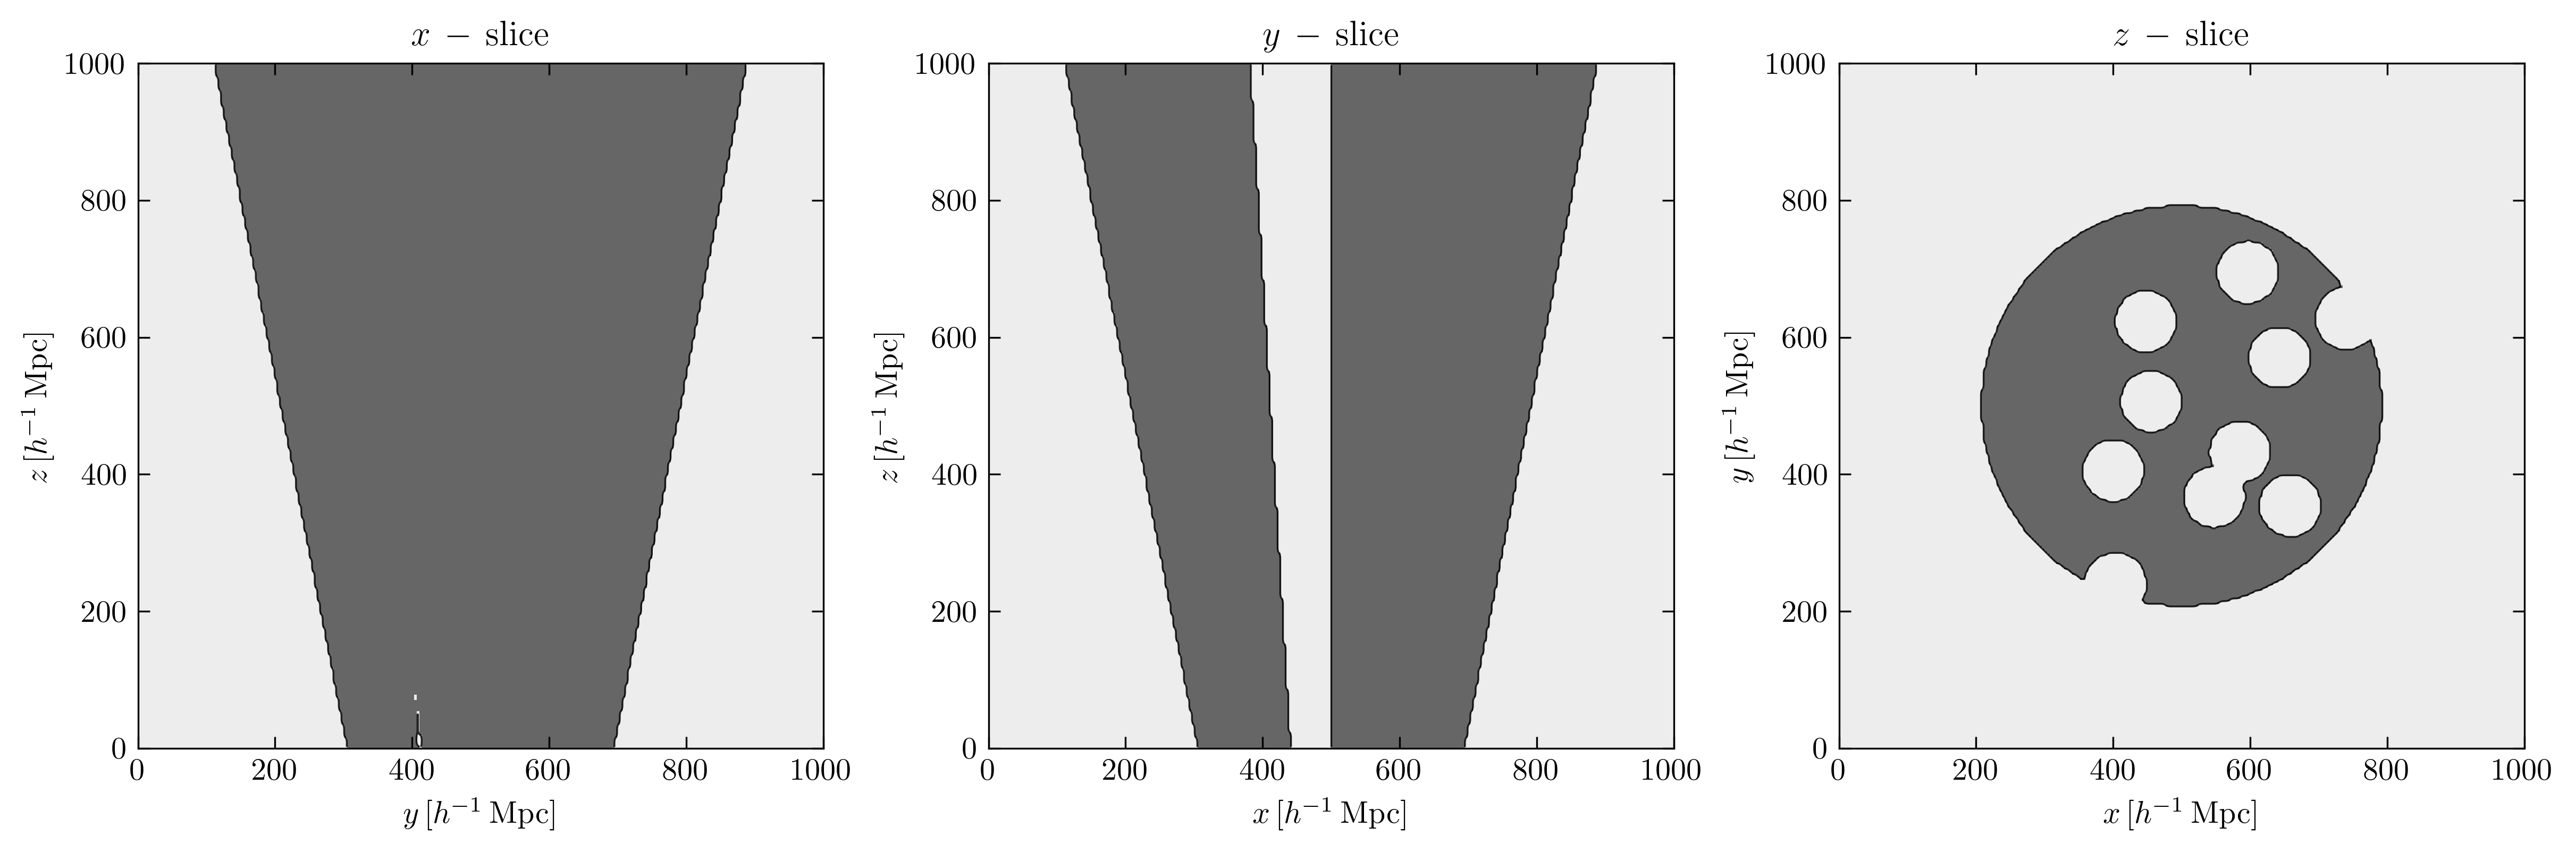

In [62]:
import importlib, helper_tools, Data, Observed_Data, Reconstructed_Field, Wiener_solver, pspectra_camb, Box, Cosmology
importlib.reload(helper_tools)
importlib.reload(Data)
importlib.reload(Observed_Data)
importlib.reload(Reconstructed_Field)
importlib.reload(Wiener_solver)
importlib.reload(pspectra_camb)
importlib.reload(Box)
importlib.reload(Cosmology)

from Data import Data
from Reconstructed_Field import ReconstructedField
from Wiener_solver import Operators, Wiener_solve_realspace_fft, Wiener_solve_realspace_stencils, Constrained_realization_real_space_fft, Constrained_realization_real_space_stencils
import pickle, time
from helper_tools import make_cone_mask_with_subcones, plot_mask_3d, plot_mask_slices
from pspectra_camb import build_camb_pk_callable
from Box import Box
from Cosmology import Cosmology
import numpy as np
from Observed_Data import ObservedData
Om = cosmo.Om
Ob = 0.049
h  = cosmo.h
ns = cosmo.ns
s8 = 0.811
# pick a safe kmax in h/Mpc for your box (≈ 1.1 * sqrt(3) * pi/dx)
kmax_h = 1.1 * np.sqrt(3.0) * np.pi / box.dx
print('max k: ', kmax_h)
# Build CAMB ONCE and get the callable
Pk_callable, _ = build_camb_pk_callable(
    Om=Om, Ob=Ob, h=h, ns=ns,
    sigma8_target=s8,
    z=0.0,
    kmax_h=kmax_h,
    nonlinear=False
)

M, dbg = make_cone_mask_with_subcones(
    box,
    los_dir="z",
    cone_half_angle_deg=11.0,
    observer_offset_L=1.5,
    subcone_count=10,
    subcone_half_angle_deg=1.7,
    subcone_layout="random",   # <—
    seed=42,
    return_debug=True
)
print("coverage:", M.mean())
plot_mask_slices(M, box)

In [118]:
import importlib, helper_tools, Data, Observed_Data, Reconstructed_Field, Wiener_solver, pspectra_camb, Box, Cosmology
importlib.reload(helper_tools)
importlib.reload(Data)
importlib.reload(Observed_Data)
importlib.reload(Reconstructed_Field)
importlib.reload(Wiener_solver)
importlib.reload(pspectra_camb)
importlib.reload(Box)
importlib.reload(Cosmology)

from Data import Data
from Reconstructed_Field import ReconstructedField
from Wiener_solver import Operators, Wiener_solve_realspace_fft, Wiener_solve_realspace_stencils, Constrained_realization_real_space_fft, Constrained_realization_real_space_stencils
import pickle, time
from helper_tools import make_cone_mask_with_subcones, plot_mask_3d, plot_mask_slices, subcone_footprints_on_slice
from pspectra_camb import build_camb_pk_callable
from Box import Box
from Cosmology import Cosmology
import numpy as np
from Observed_Data import ObservedData


box = Box(256, 1000)
cosmo = Cosmology(1, 67.4, 0.8, 0.315, 0.674, 0.965, 1.0)

Om = cosmo.Om
Ob = 0.049
h  = cosmo.h
ns = cosmo.ns
s8 = 0.811
# pick a safe kmax in h/Mpc for your box (≈ 1.1 * sqrt(3) * pi/dx)
kmax_h = 1.1 * np.sqrt(3.0) * np.pi / box.dx
print('max k: ', kmax_h)
# Build CAMB ONCE and get the callable
Pk_callable, _ = build_camb_pk_callable(
    Om=Om, Ob=Ob, h=h, ns=ns,
    sigma8_target=s8,
    z=0.0,
    kmax_h=kmax_h,
    nonlinear=False
)

M, dbg = make_cone_mask_with_subcones(
    box,
    los_dir="z",
    cone_half_angle_deg=11.0,
    observer_offset_L=1.5,
    subcone_count=10,
    subcone_half_angle_deg=1.7,
    subcone_layout="random",   # <—
    seed=42,
    return_debug=True
)
print("coverage:", M.mean())

# Compute footprints for central z-slice
foots = subcone_footprints_on_slice(dbg, box, slice_axis='z', slice_index=n//2,
                                    use_ellipse=False)  # change to True for ellipses

obs_data = ObservedData(box, cosmo, mask=M, b_bias=1.7, dataset="real")
obs_data.generate_mock_fields(rng=np.random.default_rng(), Pk_callable=Pk_callable)
obs_data.generate_artificial_noise(3.0, 0.0)
obs_data.add_noise_and_mask()

ops_fft = Operators(box, cosmo, Pdelta_callable=Pk_callable, use_lattice_in_fft=False)
ops_sten = Operators(box, cosmo, Pdelta_callable=Pk_callable)

phi_wiener_fft, A_fft, rhs_fft = Wiener_solve_realspace_fft(ops_fft, obs_data)
phi_wiener_sten, A_sten, rhs_sten = Wiener_solve_realspace_stencils(ops_sten, obs_data)


con_phi_fft = Constrained_realization_real_space_fft(ops_fft, obs_data)
con_phi_sten = Constrained_realization_real_space_stencils(ops_sten, obs_data)


reconstructed = ReconstructedField(box, cosmo, phi_wiener_sten, phi_wiener_fft, con_phi_sten, con_phi_fft)
reconstructed.calc_delta()
reconstructed.calc_vel()





max k:  1.532297702905067
[cone] box apparent half-angle ≈ 35.26°; main cone = 11.00°
[mask] coverage (mean) after carving = 0.2153
coverage: 0.2152564525604248


/home/raeed/.local/lib/python3.8/site-packages/camb/results.py:953: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


[PCG] it=  1  |r|/|b|=9.028e-01
[PCG] it= 10  |r|/|b|=1.048e-01
[PCG] it= 20  |r|/|b|=9.349e-03
[PCG] it= 30  |r|/|b|=7.962e-04
[PCG] it= 40  |r|/|b|=6.731e-05
[PCG] it= 50  |r|/|b|=5.611e-06
[PCG] converged in 57 iters, time 186.10s
[Spectral L] total solve time: 189.28s
[PCG] it=  1  |r|/|b|=8.997e-01
[PCG] it= 10  |r|/|b|=9.848e-02
[PCG] it= 20  |r|/|b|=8.488e-03
[PCG] it= 30  |r|/|b|=7.035e-04
[PCG] it= 40  |r|/|b|=5.837e-05
[PCG] it= 50  |r|/|b|=4.782e-06
[PCG] converged in 57 iters, time 151.41s
[Stencil L] total solve time: 154.03s
Creating Pk callable
Creating Pk callable


/tmp/ipykernel_423293/1295044787.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_423293/1295044787.py:107: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


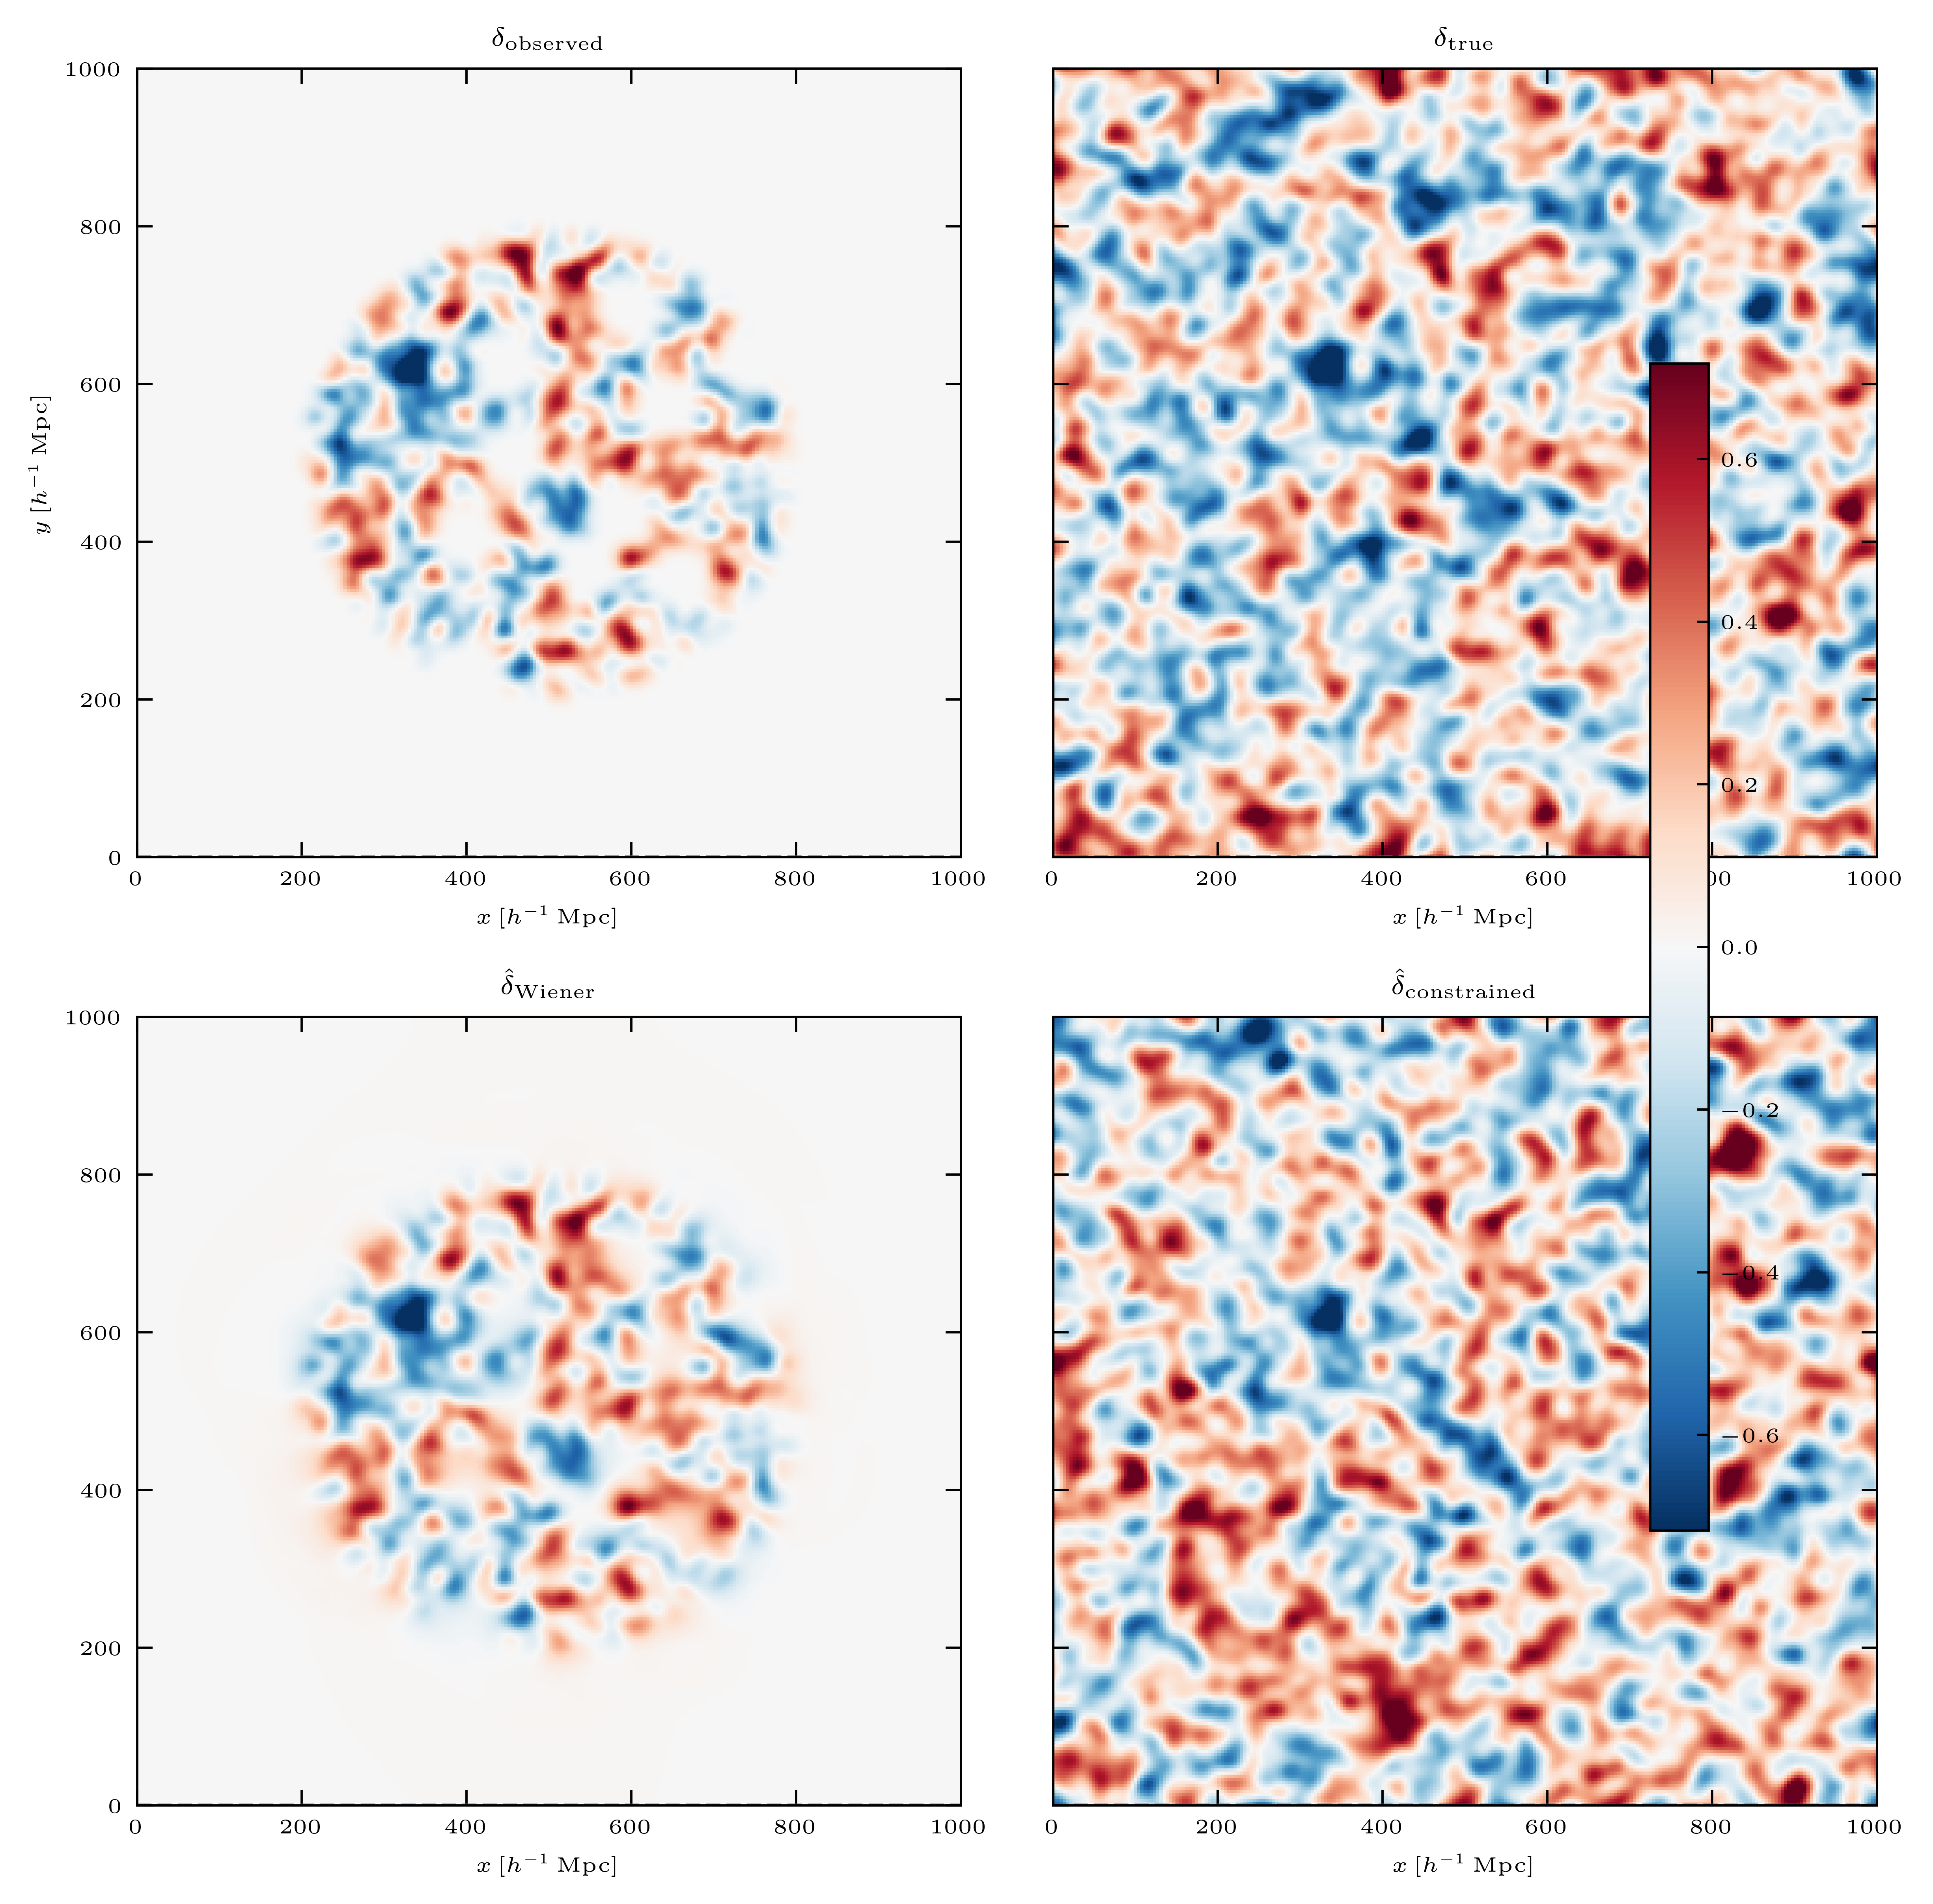

In [75]:
# --- imports you need ---
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors  # <-- missing before
from helper_tools import gaussian_smooth_fft

# --- grab fields & sanity ---
n, L = obs_data.box.n, obs_data.box.L
true_delta   = obs_data.delta_r
obs_delta = obs_data.d
Wiener_delta = reconstructed.Wiener_delta_rec_fft             # make sure names match your class
reconst_delta= reconstructed.constrained_realization_delta_fft

assert true_delta is not None and obs_delta is not None
assert Wiener_delta is not None and reconst_delta is not None

# --- smoothing ---
R_smooth = 10.0  # Mpc/h
true   = gaussian_smooth_fft(true_delta,   obs_data.box, R_smooth)
obs    = gaussian_smooth_fft(obs_delta, obs_data.box, R_smooth)
W_fft  = gaussian_smooth_fft(Wiener_delta, obs_data.box, R_smooth)
C_fft  = gaussian_smooth_fft(reconst_delta, obs_data.box, R_smooth)

# --- central slice ---
iz = n // 2
sl_true = true[:, :, iz]
sl_obs        = obs[:, :, iz] / 1.7
sl_Wiener_fft = W_fft[:, :, iz]
sl_const_fft  = C_fft[:, :, iz]

# shared symmetric color scale (robust)
vals = np.concatenate([
    sl_true.ravel(), sl_obs.ravel(),
    sl_Wiener_fft.ravel(), sl_const_fft.ravel()
])
vmax = np.percentile(np.abs(vals), 99.5)
vmin = -vmax
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
extent = [0, L, 0, L]  # x,y in Mpc/h

# --- LaTeX plotting style ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

fig, axes = plt.subplots(2, 2, figsize=(4, 3), dpi=700, sharey=True, constrained_layout=True)

# (1) true
im0 = axes[0, 1].imshow(sl_true.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[0, 1].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0, 1].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
#axes[0, 1].set_ylabel(r'$z\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[0, 1].set_title(r'$\delta_{\mathrm{true}}$', fontsize=7)

# (2) observed (masked+noise)
im1 = axes[0, 0].imshow(sl_obs.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[0, 0].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0, 0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[0, 0].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[0, 0].set_title(r'$\delta_{\mathrm{observed}}$', fontsize=7)

# (3) Wiener
im2 = axes[1, 0].imshow(sl_Wiener_fft.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[1, 0].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1, 0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
#axes[1, 0].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[1, 0].set_title(r'$\hat{\delta}_{\mathrm{Wiener}}$', fontsize=7)

# (4) constrained realization
im3 = axes[1, 1].imshow(sl_const_fft.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)  # <-- was sl_Wiener_fft
axes[1, 1].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1, 1].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
#axes[1, 1].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[1, 1].set_title(r'$\hat{\delta}_{\mathrm{constrained}}$', fontsize=7)

# --- one shared colorbar for all axes ---
cbar = fig.colorbar(
    im3, ax=axes.ravel().tolist(),
    shrink=0.8,
    fraction=0.05,
    pad=0.06,
    #format="%.1e",
)
cbar.ax.tick_params(labelsize=5.5, width=0.6, length=3, direction="in")
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.6)

# Ticks styling
def bold_formatter_int(x, pos): return r'${:.0f}$'.format(x)
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', direction='in', labelsize=5.5)
    ax.tick_params(axis='both', which='major', length=4, width=0.6)
    ax.tick_params(axis='both', which='minor', length=2, width=0.6)
    ax.tick_params(top=True, bottom=True, left=True, right=True)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
    ax.set_aspect("auto")
plt.tight_layout()
plt.savefig('reconstructed_fields.png', dpi=700)


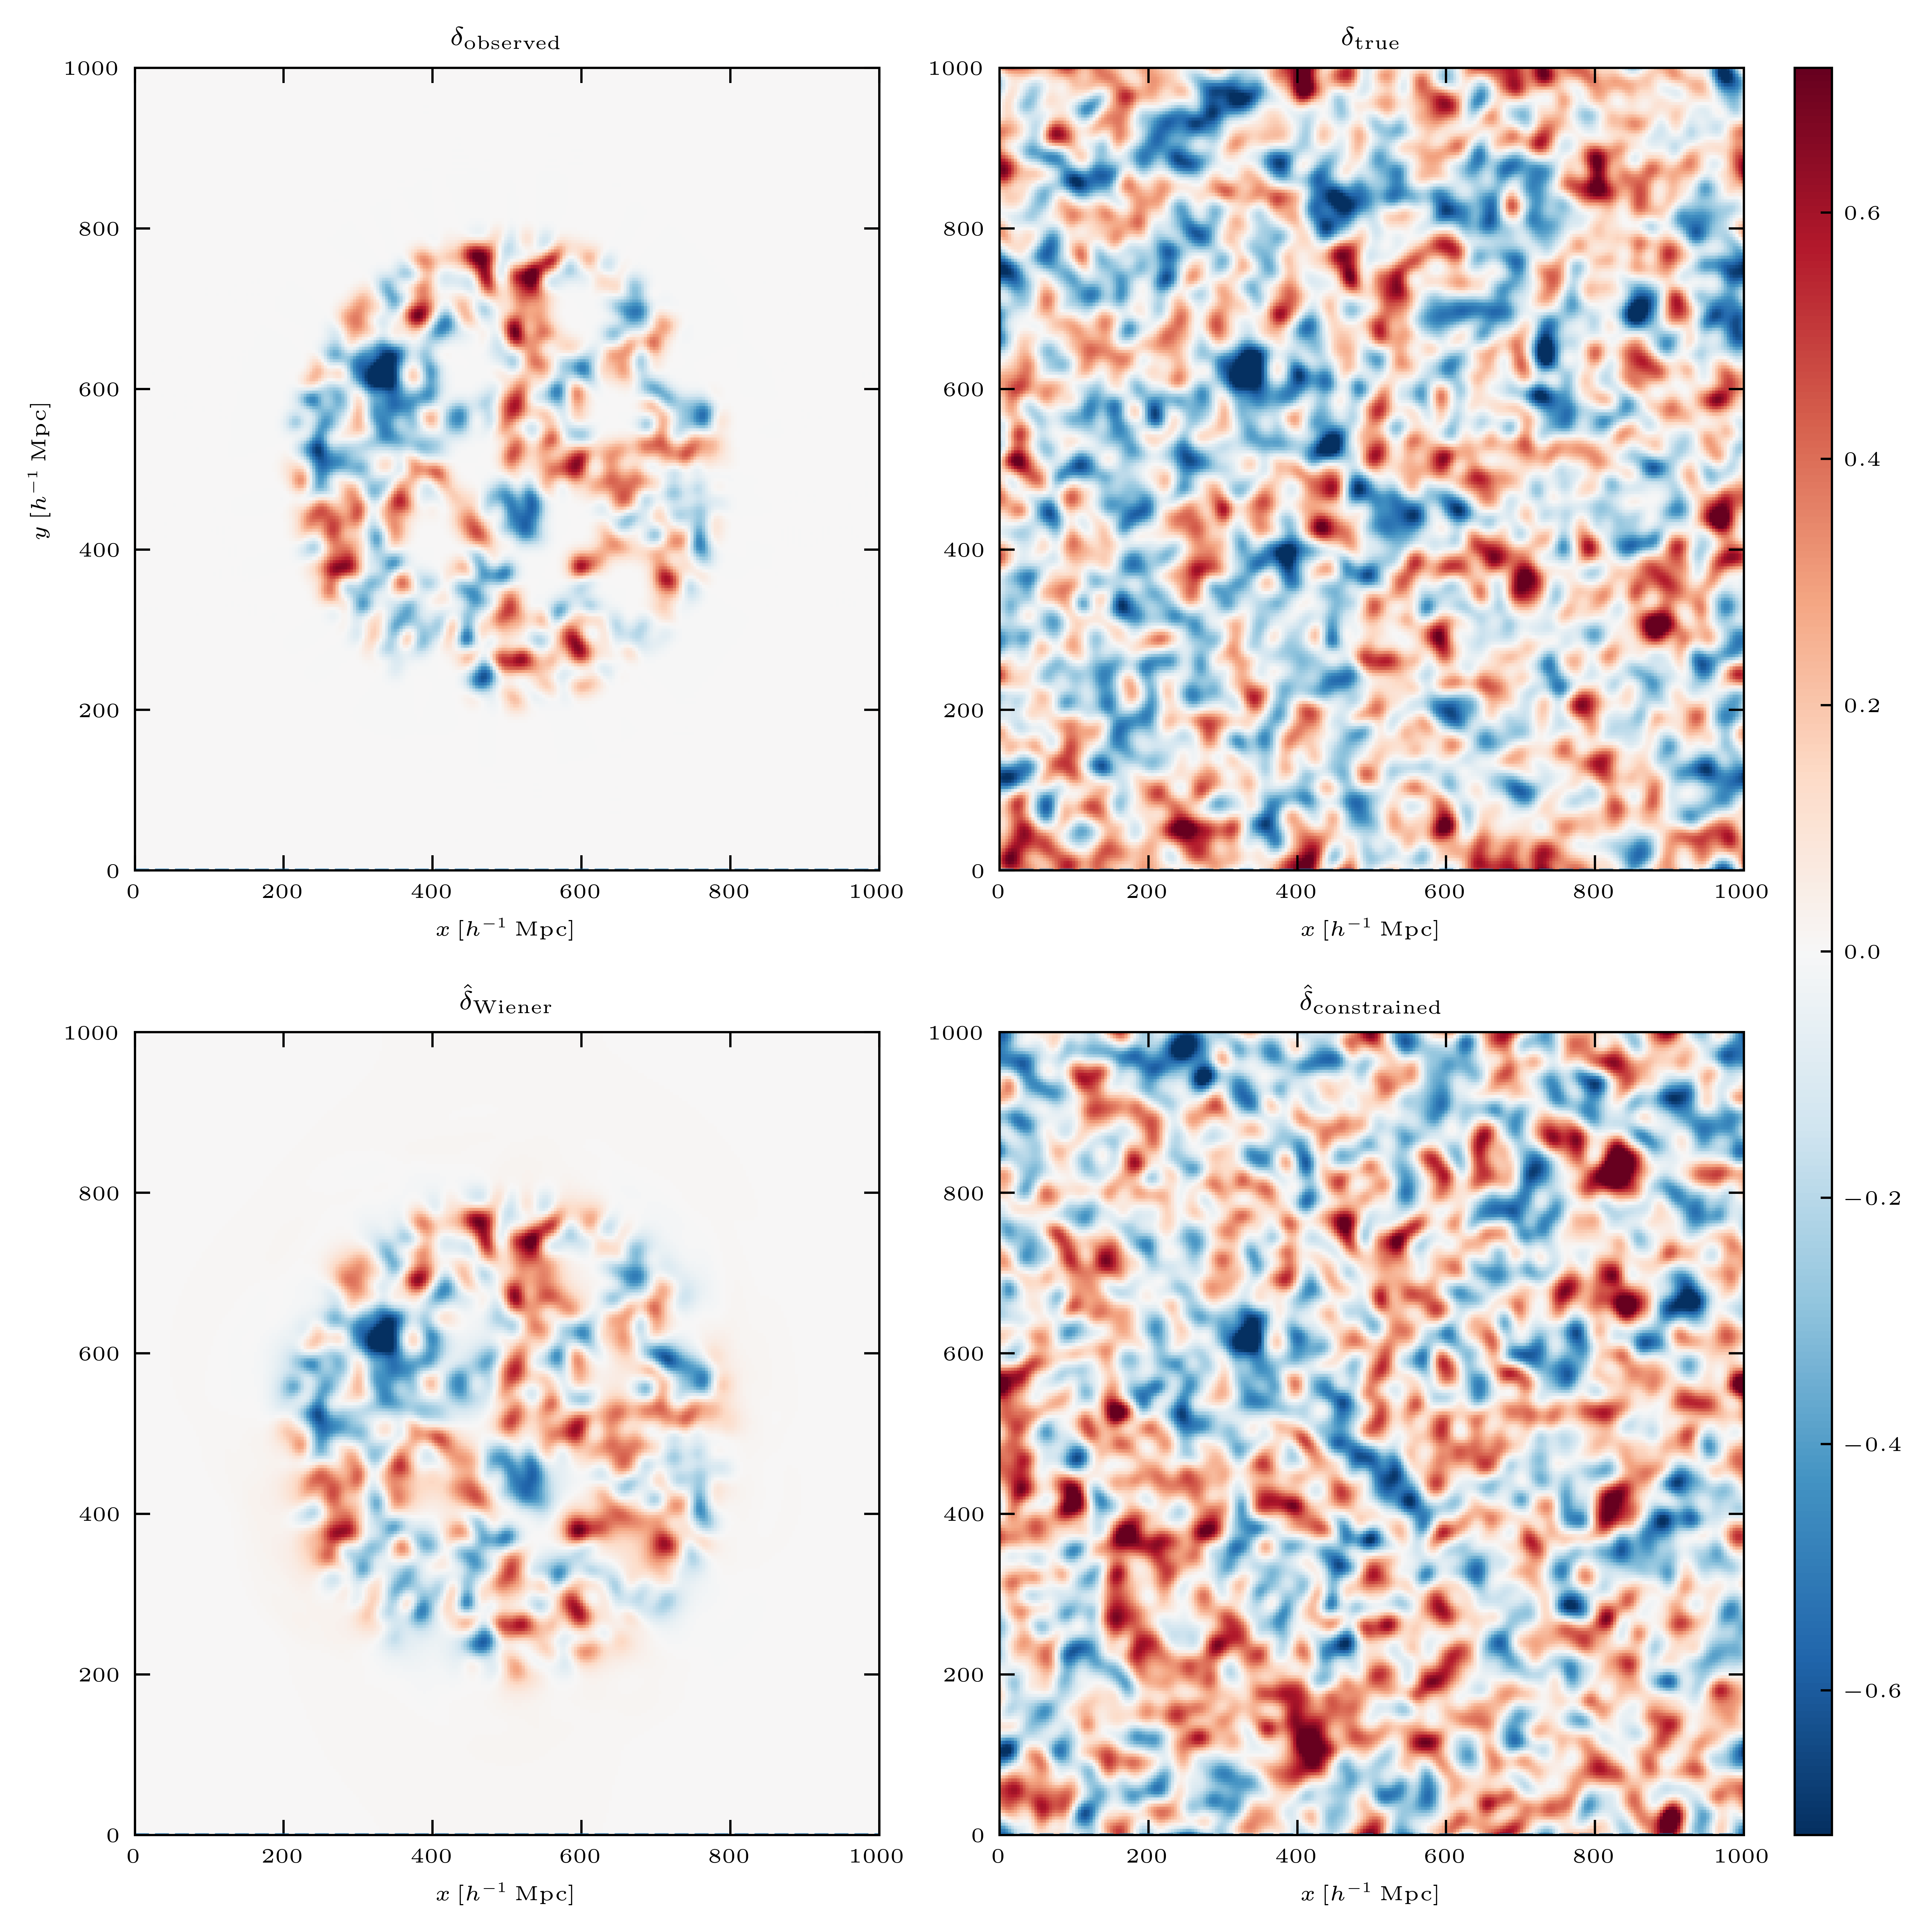

In [84]:
# --- LaTeX plotting style ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

# --- figure with a dedicated colorbar column ---
fig = plt.figure(figsize=(7, 7), dpi=700, constrained_layout=True)
gs  = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.02, hspace=0.02)

axes = np.array([
    [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])],
])
cax = fig.add_subplot(gs[:, 2])  # colorbar axis spans both rows

# (1) observed (masked+noise)
im0 = axes[0, 0].imshow(sl_obs.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[0, 0].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0, 0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[0, 0].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[0, 0].set_title(r'$\delta_{\mathrm{observed}}$', fontsize=7)

# (2) true
im1 = axes[0, 1].imshow(sl_true.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[0, 1].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0, 1].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[0, 1].set_title(r'$\delta_{\mathrm{true}}$', fontsize=7)

# (3) Wiener
im2 = axes[1, 0].imshow(sl_Wiener_fft.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[1, 0].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1, 0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[1, 0].set_title(r'$\hat{\delta}_{\mathrm{Wiener}}$', fontsize=7)

# (4) constrained realization
im3 = axes[1, 1].imshow(sl_const_fft.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[1, 1].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1, 1].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[1, 1].set_title(r'$\hat{\delta}_{\mathrm{constrained}}$', fontsize=7)

# --- shared colorbar on its own axis ---
cbar = fig.colorbar(im3, cax=cax)
cbar.ax.tick_params(labelsize=5.5, width=0.6, length=3, direction="in")
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.6)

# Ticks styling
def bold_formatter_int(x, pos): return r'${:.0f}$'.format(x)
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', direction='in', labelsize=5.5)
    ax.tick_params(axis='both', which='major', length=4, width=0.6)
    ax.tick_params(axis='both', which='minor', length=2, width=0.6)
    ax.tick_params(top=True, bottom=True, left=True, right=True)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
    ax.set_aspect("auto")

plt.savefig('reconstructed_fields.png', dpi=700,
            bbox_inches='tight', facecolor='white', edgecolor='white', transparent=False)


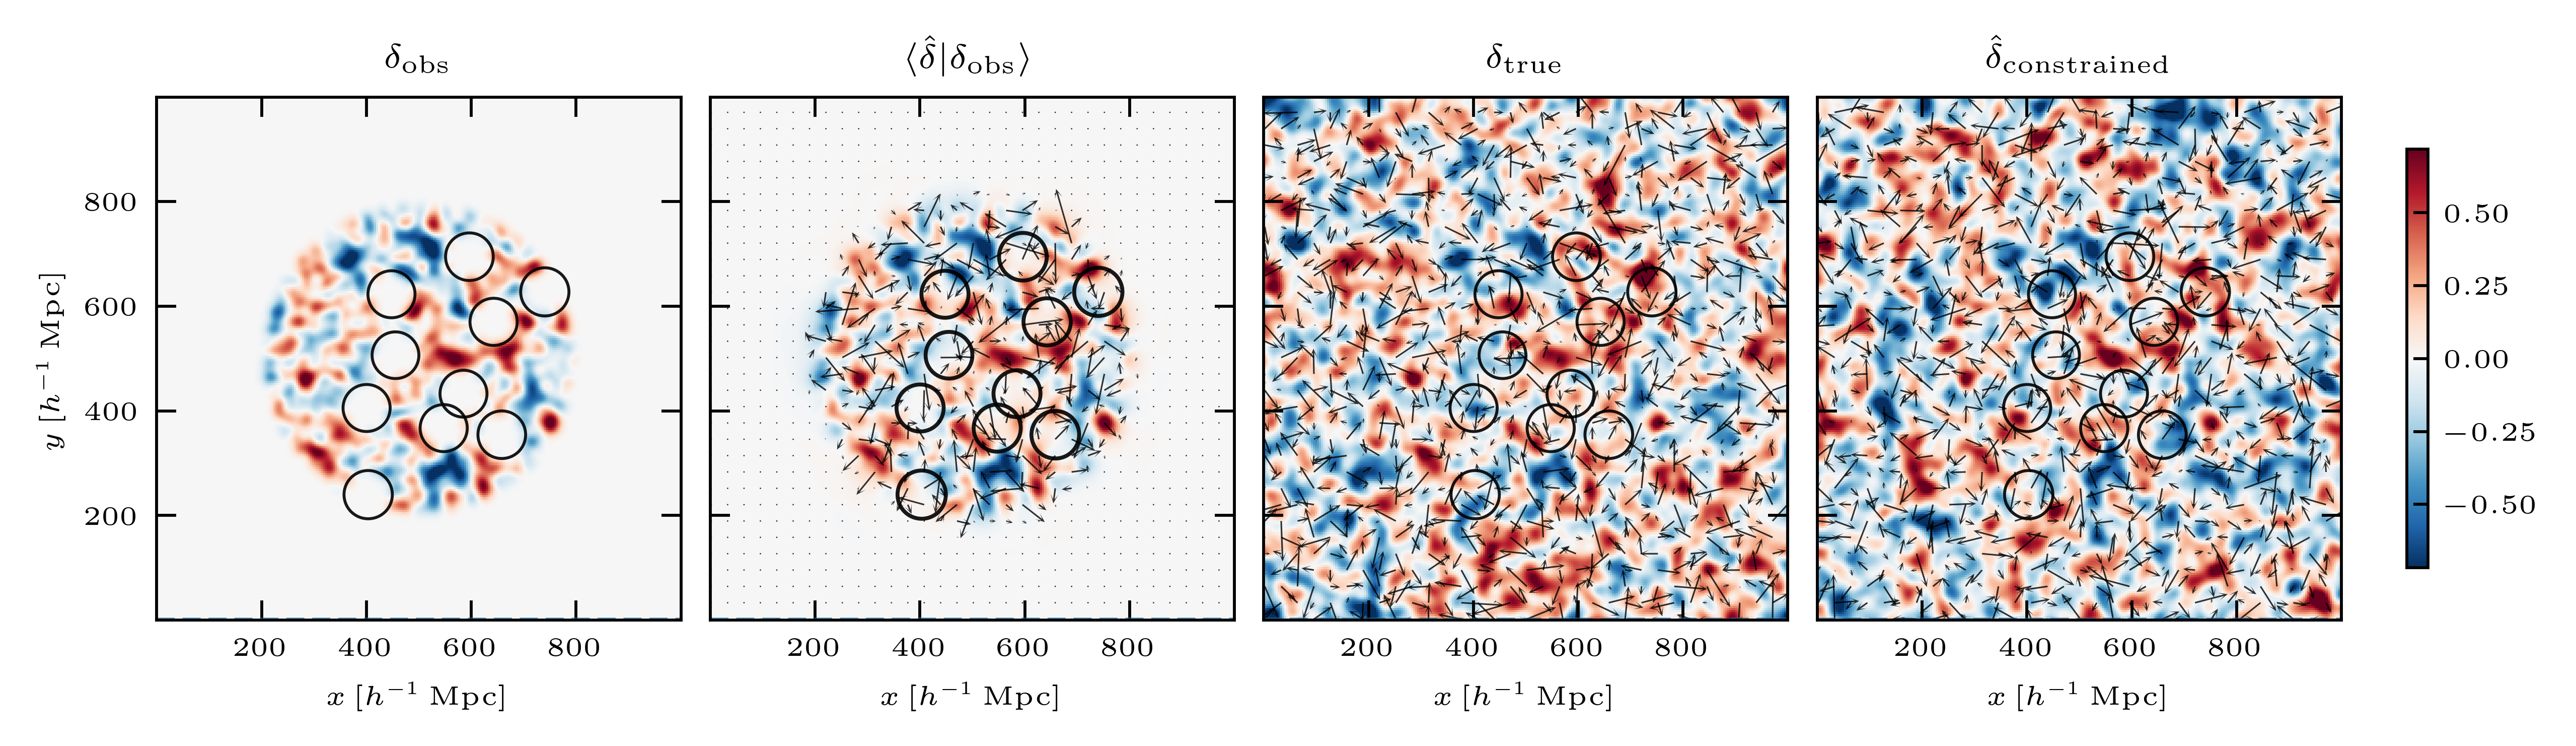

In [145]:
import importlib, helper_tools, Reconstructed_Field
importlib.reload(helper_tools)
importlib.reload(Reconstructed_Field)

from matplotlib.patches import Circle, Ellipse
from helper_tools import subcone_footprints_on_slice, make_cone_mask_with_subcones
from Reconstructed_Field import velocity_from_phi

# --- grab fields & sanity ---
n, L = obs_data.box.n, obs_data.box.L
true_delta   = obs_data.delta_r
obs_delta = obs_data.d
Wiener_delta = reconstructed.Wiener_delta_rec_fft             # make sure names match your class
reconst_delta= reconstructed.constrained_realization_delta_fft

assert true_delta is not None and obs_delta is not None
assert Wiener_delta is not None and reconst_delta is not None

# Compute footprints for central z-slice
foots = subcone_footprints_on_slice(dbg, box, slice_axis='z', slice_index=n//2,
                                    use_ellipse=False)  # change to True for ellipses



    # If you used ellipses instead:
    # ell = Ellipse((f["x"], f["y"]), width=2*f["a"], height=2*f["b"], angle=f["theta_deg"],
    #               edgecolor='k', facecolor='none', lw=0.8, alpha=0.9)
    # ax.add_patch(ell)


# --- smoothing ---
R_smooth = 10.0  # Mpc/h
true   = gaussian_smooth_fft(true_delta,   obs_data.box, R_smooth)
obs    = gaussian_smooth_fft(obs_delta, obs_data.box, R_smooth)
W_fft  = gaussian_smooth_fft(Wiener_delta, obs_data.box, R_smooth)
C_fft  = gaussian_smooth_fft(reconst_delta, obs_data.box, R_smooth)

# --- central slice ---
iz = n // 2
sl_true = true[:, :, iz]
sl_obs        = obs[:, :, iz] / 1.7
sl_Wiener_fft = W_fft[:, :, iz]
sl_const_fft  = C_fft[:, :, iz]

# --- LaTeX plotting style ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

# --- figure with a dedicated colorbar column ---
fig, axes = plt.subplots(1, 4, figsize=(7.2, 2), dpi=700, constrained_layout=True, sharey=True)


# axes = np.array([
#     [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
#     [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])],
# ])
# cax = fig.add_subplot(gs[:, 2])  # colorbar axis spans both rows

# (1) observed (masked+noise)
im0 = axes[0].imshow(sl_obs.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
im0.set_zorder(0)
axes[0].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[0].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[0].set_title(r'$\delta_{\mathrm{obs}}$', fontsize=7)
axes[0].set_xlim(0.0001,999.999)
axes[0].set_ylim(0.0001,999.999)

# (2) true
im1 = axes[2].imshow(sl_true.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[2].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[2].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[0].set_ylabel(r'$y\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[2].set_title(r'$\delta_{\mathrm{true}}$', fontsize=7)
axes[2].set_xlim(0.0001,999.999)
axes[2].set_ylim(0.0001,999.999)

# (3) Wiener
im2 = axes[1].imshow(sl_Wiener_fft.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[1].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[1].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[1].set_title(r'$\langle\hat{\delta}|\delta_{\mathrm{obs}}\rangle$', fontsize=7)
axes[1].set_xlim(0.0001,999.999)
axes[1].set_ylim(0.0001,999.999)


# (4) constrained realization
im3 = axes[3].imshow(sl_const_fft.T, origin="lower", extent=extent, cmap="RdBu_r", norm=norm)
axes[3].axhline(0.0, lw=1, ls='--', alpha=0.7)
axes[3].set_xlabel(r'$x\,[h^{-1}\,\mathrm{Mpc}]$', fontsize=5.5)
axes[3].set_title(r'$\hat{\delta}_{\mathrm{constrained}}$', fontsize=7)
axes[3].set_xlim(0.0001,999.999)
axes[3].set_ylim(0.0001,999.999)

ax = axes[0]  # whichever subplot shows that same z-slice

for f in foots:
    # Circles:
    circ = Circle((f["x"], f["y"]), radius=f["r"],
                  edgecolor='k', facecolor='none', zorder=15, lw=0.6, alpha=0.9)
    ax.add_patch(circ)

ax = axes[1]  # whichever subplot shows that same z-slice

for f in foots:
    # Circles:
    circ = Circle((f["x"], f["y"]), radius=f["r"],
                  edgecolor='k', facecolor='none', zorder=15, lw=0.8, alpha=0.9)
    ax.add_patch(circ)

ax = axes[2]  # whichever subplot shows that same z-slice

for f in foots:
    # Circles:
    circ = Circle((f["x"], f["y"]), radius=f["r"],
                  edgecolor='k', facecolor='none', zorder=15, lw=0.6, alpha=0.9)
    ax.add_patch(circ)

ax = axes[3]  # whichever subplot shows that same z-slice

for f in foots:
    # Circles:
    circ = Circle((f["x"], f["y"]), radius=f["r"],
                  edgecolor='k', facecolor='none', zorder=15, lw=0.6, alpha=0.9)
    ax.add_patch(circ)

# --- overlay velocity quivers on Wiener & constrained panels (FFT branch) ---
# Grab (vx, vy, vz); slice on the same z-index
vel_tr = velocity_from_phi(true, box, mode='spectral')
#vel_tr = getattr(obs_data, "v_fft", None)
#vel_w = getattr(reconstructed, "Wiener_vel_rec_fft", None)
vel_w = velocity_from_phi(W_fft, box, mode='spectral')
vel_c = velocity_from_phi(C_fft, box, mode='spectral')
#vel_c = getattr(reconstructed, "constrained_realization_vel_fft", None)

##########################################################################################################
#########################################################################################################


# positions at cell centers (match imshow extent)
dx = L / n
x = (np.arange(n) + 0.5) * dx
y = (np.arange(n) + 0.5) * dx
X, Y = np.meshgrid(x, y, indexing="ij")

# downsample quiver grid and normalize arrow lengths
qstep = max(1, n // 32)         # density of arrows; increase for fewer arrows
arrow_frac = 0.08               # arrow length ~ this fraction of box size for 99th-percentile speed

def quiver_on(ax, vx3d, vy3d, title_for_key=None):
    vx2 = vx3d[:, :, iz]
    vy2 = vy3d[:, :, iz]
    # normalize to a fixed display length
    mag = np.hypot(vx2, vy2)
    s99 = np.percentile(mag, 99.0) + 1e-20
    U = (vx2 / s99) * (arrow_frac * L)
    V = (vy2 / s99) * (arrow_frac * L)
    Q = ax.quiver(
        X[::qstep, ::qstep], Y[::qstep, ::qstep],
        U[::qstep, ::qstep].T, V[::qstep, ::qstep].T,   # transpose to match imshow .T
        color="k", angles="xy", scale_units="xy", scale=1.0,
        width=0.003, headwidth=5, headlength=6, headaxislength=2.5, alpha=0.8
    )
    # if title_for_key:
    #     ax.quiverkey(Q, 0.05, 0.95, arrow_frac * L, title_for_key,
    #                  coordinates='axes', labelpos='E', fontproperties={'size': 5.5})

# true velocity overlay
if vel_tr is not None:
    quiver_on(axes[2], vel_tr[0], vel_tr[1], title_for_key=r'$|\mathbf{v}|_{99\%}$')

# Wiener velocity overlay
if vel_w is not None:
    quiver_on(axes[1], vel_w[0], vel_w[1], title_for_key=r'$|\mathbf{v}|_{99\%}$')

# Constrained velocity overlay
if vel_c is not None:
    quiver_on(axes[3], vel_c[0], vel_c[1], title_for_key=r'$|\mathbf{v}|_{99\%}$')

# --- one shared colorbar for all axes ---
cbar = fig.colorbar(
    im3, ax=axes.ravel().tolist(),
    shrink=0.8,
    fraction=0.05,
    pad=0.03,
    #format="%.1e",
)
cbar.ax.tick_params(labelsize=5.5, width=0.6, length=3, direction="in")
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.6)

# Ticks styling
def bold_formatter_int(x, pos): return r'${:.0f}$'.format(x)
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', direction='in', labelsize=5.5)
    ax.tick_params(axis='both', which='major', length=4, width=0.6)
    ax.tick_params(axis='both', which='minor', length=2, width=0.6)
    ax.tick_params(top=True, bottom=True, left=True, right=True)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(bold_formatter_int))
    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
    ax.set_aspect("auto")
fig.canvas.draw_idle()
plt.savefig('reconstructed_fields_with_vel.png', dpi=700,
            bbox_inches='tight', facecolor='white', edgecolor='white', transparent=False)



In [71]:
from matplotlib.patches import Circle, Ellipse

# after you create the image:
im = ax.imshow(sl_obs.T, origin="lower", extent=[0,L,0,L], cmap="RdBu_r", norm=norm)
im.set_zorder(0)                 # make sure image is at the bottom
ax.set_xlim(0, L); ax.set_ylim(0, L)



# overlay footprints on TOP
for f in foots:
    if "r" in f:  # circle
        circ = Circle((f["x"], f["y"]), f["r"],
                      facecolor="none", edgecolor="yellow",
                      lw=1.2, alpha=0.95, zorder=15, clip_on=False)
        ax.add_patch(circ)
    else:         # ellipse
        ell = Ellipse((f["x"], f["y"]), width=2*f["a"], height=2*f["b"],
                      angle=f["theta_deg"],
                      facecolor="none", edgecolor="yellow",
                      lw=1.2, alpha=0.95, zorder=15, clip_on=False)
        ax.add_patch(ell)

# if needed, ensure matching coordinates and no autoscale:
ax.set_xlim(0, L); ax.set_ylim(0, L)
fig.canvas.draw_idle()


1.3282819097081


C:\Users\Raeed\AppData\Local\Temp\ipykernel_25224\3872504125.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


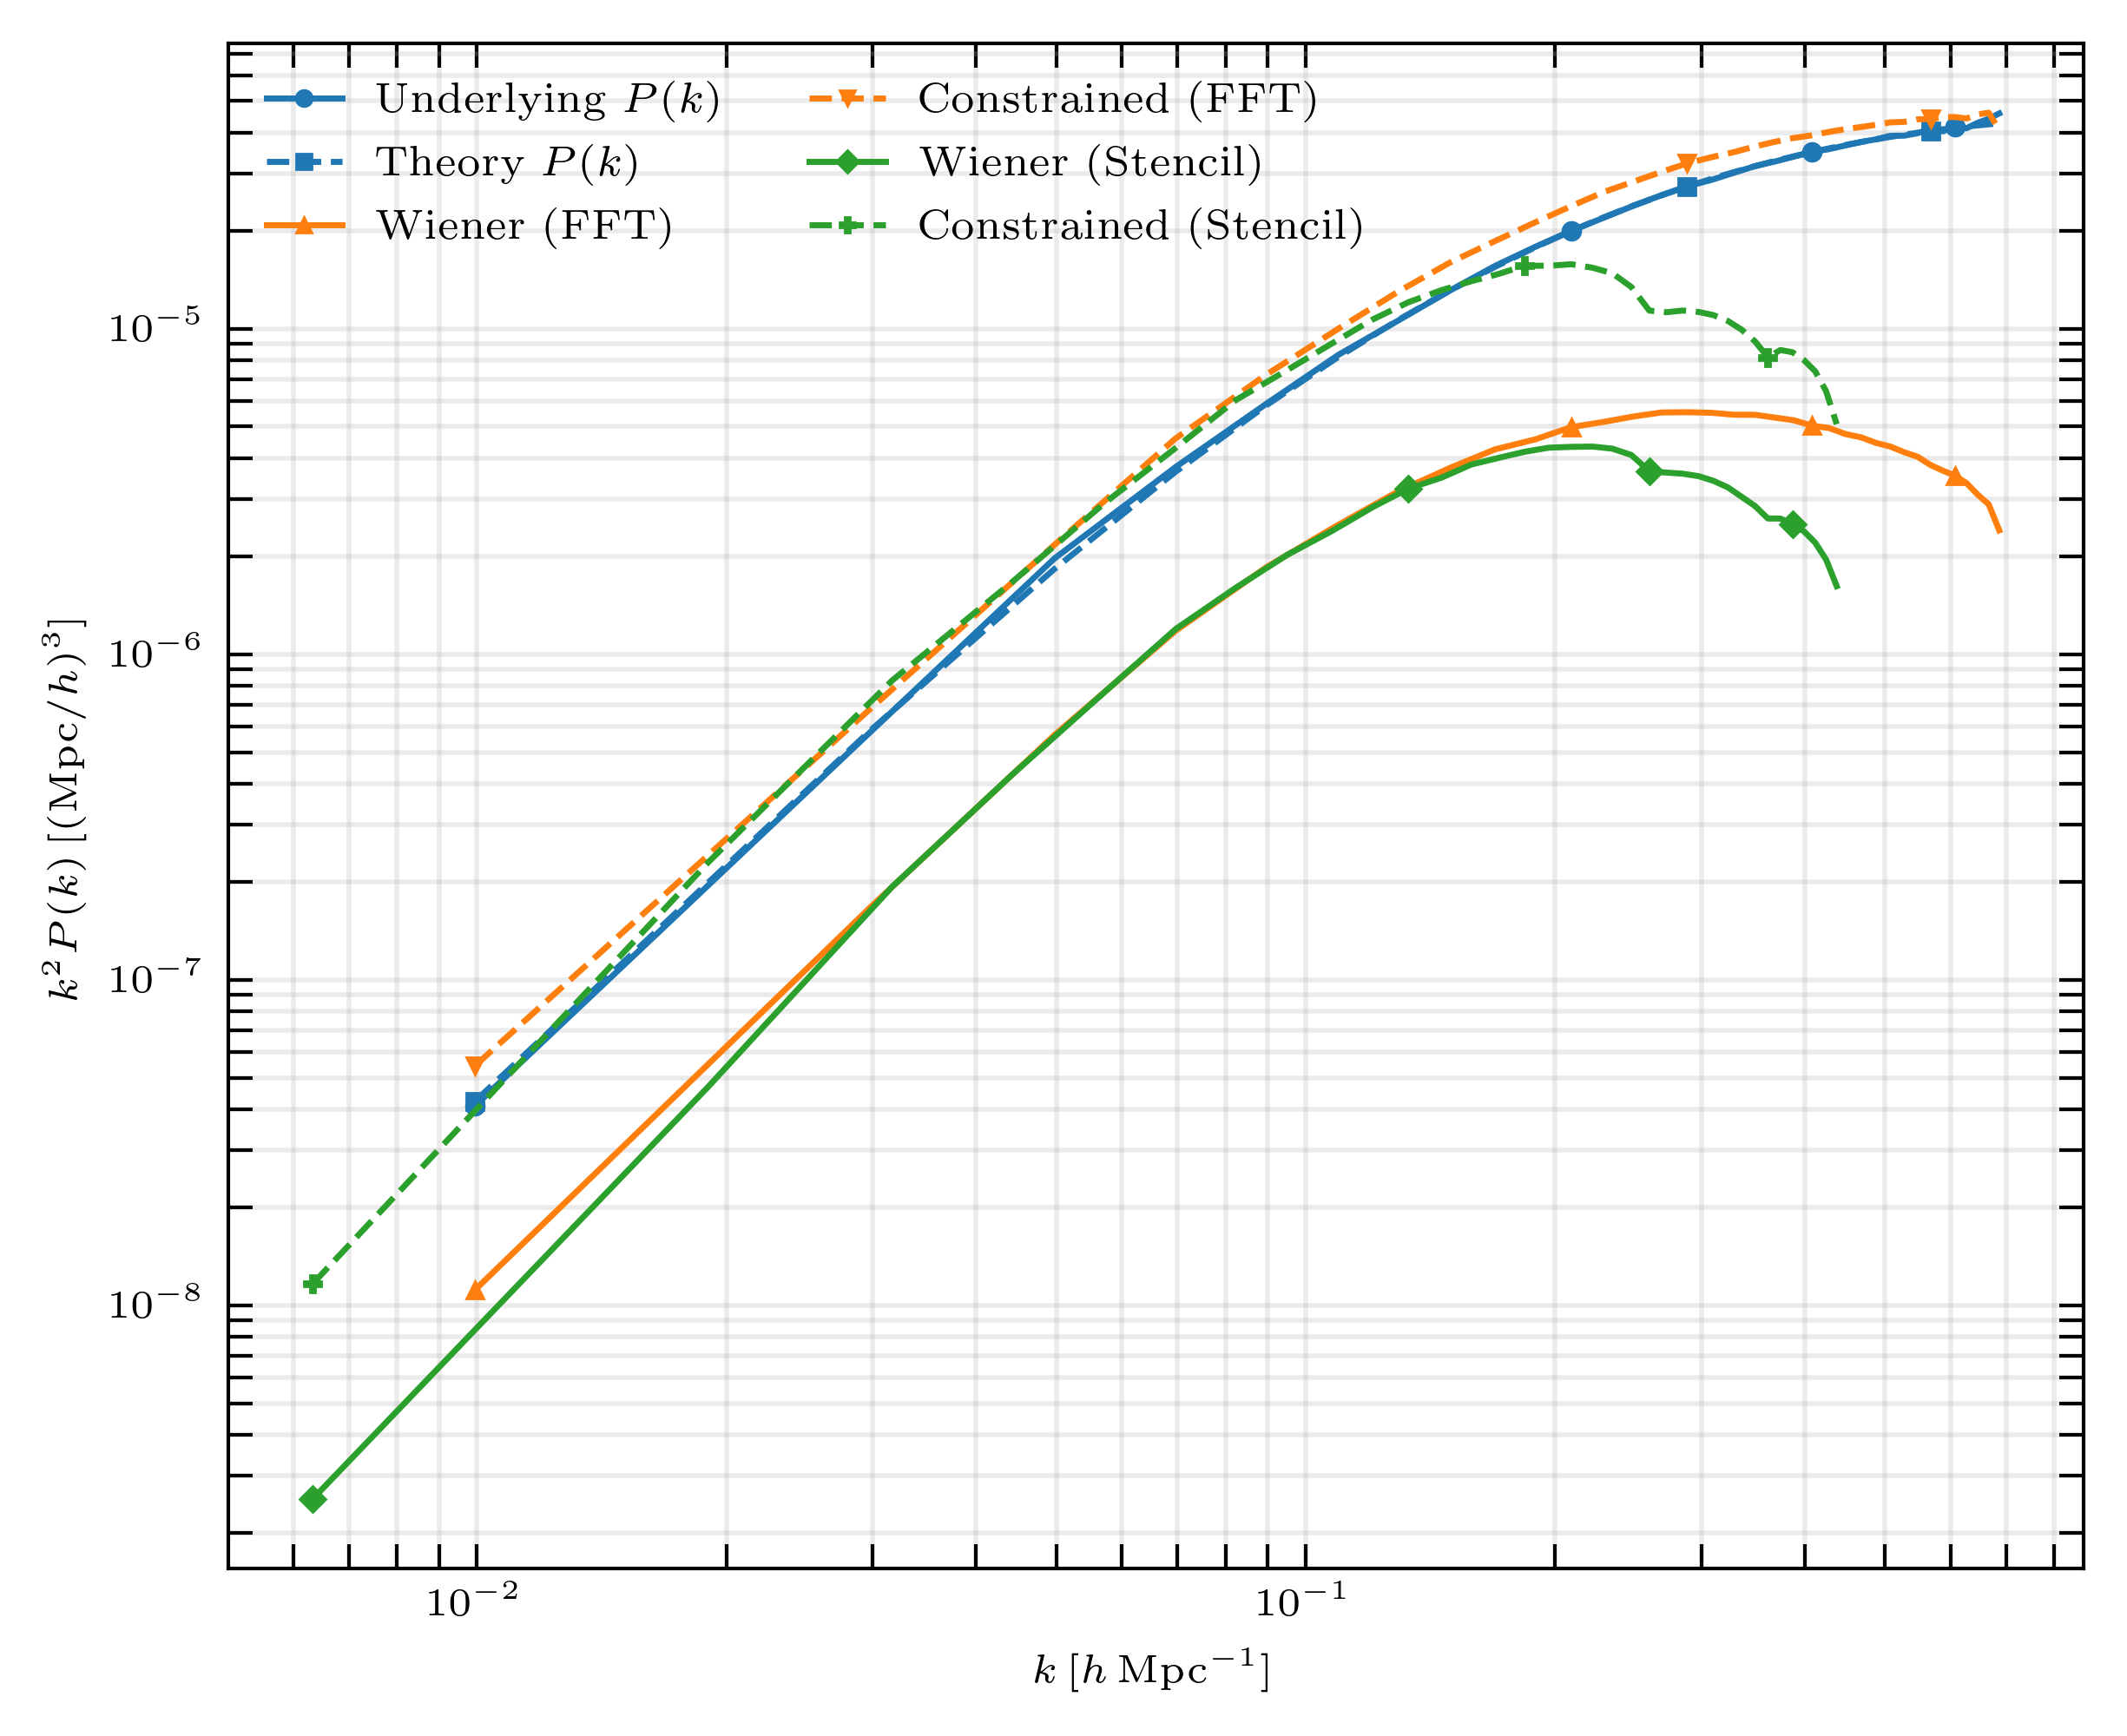

In [129]:
# === Smooth slice + Power spectrum (side by side) ===
import importlib, helper_tools
importlib.reload(helper_tools)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from helper_tools import gaussian_smooth_fft, shell_power_rfft, shell_power_rfft_stencil
from pspectra import Pk_phys_nowiggle


Wiener_delta_sten = reconstructed.Wiener_delta_rec_sten
const_delta_sten = reconstructed.constrained_realization_delta_sten
# --- 1D shell-averaged P(k) from the raw field (not the smoothed one) ---
# --- 1D shell-averaged P(k) ---
NBINS = 35
k_true,  P_true,  _ = shell_power_rfft(true_delta,   L, NBINS)
k_wfF,   P_WF_F,  _ = shell_power_rfft(Wiener_delta, L, NBINS)
k_crF,   P_CR_F,  _ = shell_power_rfft(reconst_delta, L, NBINS)
k_wfS,   P_WF_S,  _ = shell_power_rfft_stencil(Wiener_delta_sten, L, NBINS)
k_crS,   P_CR_S,  _ = shell_power_rfft_stencil(const_delta_sten,  L, NBINS)

# Theory on the true k-grid (you can also eval on each k_* if you prefer)
cosmo = getattr(data, "cosmology", None)
params = dict(
    Om=getattr(cosmo, "Om", 0.315),
    h =getattr(cosmo, "h",  0.674),
    ns=getattr(cosmo, "ns", 0.965),
    A =getattr(cosmo, "A",  1.0),
)
P_th_true = Pk_phys_nowiggle(k_true, **params)

# --- Plot ---
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.ticker as mticker
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.linewidth": 2,
    "axes.labelweight": "bold",
    "figure.constrained_layout.use": True,
})
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

fig, axes = plt.subplots(figsize=(5, 4.1), dpi=500)

lw, ms, mew = 1.0, 3.0, 0.4  # thinner lines & markers
m1, m2 = 10, 14              # markevery

# masks per k-grid
m_true = (k_true > 0); m_wfF = (k_wfF > 0); m_crF = (k_crF > 0); m_wfS = (k_wfS > 0); m_crS = (k_crS > 0)

# group colors: C0 true/theory, C1 FFT, C2 stencil
axes.loglog(k_true[m_true], (k_true[m_true]**2)*P_true[m_true],
            color="C0", lw=lw, ls="-",  marker="o", ms=ms, mew=mew, markevery=m1,
            label=r"Underlying $P(k)$")
axes.loglog(k_true[m_true], (k_true[m_true]**2)*P_th_true[m_true],
            color="C0", lw=lw, ls="--", marker="s", ms=ms, mew=mew, markevery=m2,
            label=r"Theory $P(k)$")

axes.loglog(k_wfF[m_wfF], (k_wfF[m_wfF]**2)*P_WF_F[m_wfF],
            color="C1", lw=lw, ls="-",  marker="^", ms=ms, mew=mew, markevery=m1,
            label=r"Wiener (FFT)")
axes.loglog(k_crF[m_crF], (k_crF[m_crF]**2)*P_CR_F[m_crF],
            color="C1", lw=lw, ls="--", marker="v", ms=ms, mew=mew, markevery=m2,
            label=r"Constrained (FFT)")

axes.loglog(k_wfS[m_wfS], (k_wfS[m_wfS]**2)*P_WF_S[m_wfS],
            color="C2", lw=lw, ls="-",  marker="D", ms=ms, mew=mew, markevery=m1,
            label=r"Wiener (Stencil)")
axes.loglog(k_crS[m_crS], (k_crS[m_crS]**2)*P_CR_S[m_crS],
            color="C2", lw=lw, ls="--", marker="P", ms=ms, mew=mew, markevery=m2,
            label=r"Constrained (Stencil)")

axes.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$", fontsize=6.5)
axes.set_ylabel(r"$k^2P(k)\,[(\mathrm{Mpc}/h)^3]$", fontsize=6.5)
axes.grid(True, which="both", alpha=0.25)
axes.legend(loc="best", fontsize=7, frameon=False, ncol=2, handlelength=1.8, markerscale=0.9)

for spine in axes.spines.values():
    spine.set_linewidth(0.6)
axes.tick_params(axis='both', which='both', direction='in', labelsize=6.5,
                 top=True, bottom=True, left=True, right=True,
                 length=4, width=0.6)
plt.tight_layout()
plt.savefig('reconstructed_p_spectrum', dpi=500)
